In [1]:
from pathlib import Path

MAX_DATA_PATH = Path("C:/Users/maxpd/Desktop/483 ML/Intrusion Detection/483-final-project-datasets/OPCUA_dataset_public.csv")
CHRIS_DATA_PATH = Path("/Users/chriszinati/Desktop/CPSC-483/final project datasets/483-final-project-datasets/OPCUA_dataset_public.csv")

**Data Cleaning**
- delete rows with missing data
- get rid of noisy data (in our case, all non-ddos anomalies)
- drop the multiclass target label (since were only looking at ddos vs normal (1 or 0))
- dropped source and destination ip and port (useless features)

In [2]:
import pandas as pd
#Stops showing values in scientific notation
pd.set_option('display.float_format', lambda x: f'{x:.4f}')


#it isn't reading just the relative path for some reason, so use the whole path
df = pd.read_csv(CHRIS_DATA_PATH)

instancesToDrop= ['MITM', 'Impersonation'] 
df = (df[df.multi_label.isin(instancesToDrop) == False]) #drop instances of MITM and Impersonation
df = df.drop('multi_label', axis=1) #drop multiclass label
df = df.drop('src_ip', axis=1) #drop source ip label
df = df.drop('src_port', axis=1) #drop source port label
df = df.drop('dst_ip', axis=1) #drop destination ip label
df = df.drop('dst_port', axis=1) #drop destination port label
print(df) #should be 107578 rows x 26 columns insetead of  107634 rows x 32 columns now



        flags  pktTotalCount  octetTotalCount   avg_ps  proto  \
0           1              2              219 109.5000  OPCUA   
1           1              2              219 109.5000  OPCUA   
2           1              2              399 199.5000  OPCUA   
3           1              2              399 199.5000  OPCUA   
4           1              2              219 109.5000  OPCUA   
...       ...            ...              ...      ...    ...   
107628      1              2              359 179.5000  OPCUA   
107629      1              2              358 179.0000  OPCUA   
107630      1              2              359 179.5000  OPCUA   
107631      1              2              359 179.5000  OPCUA   
107632      1              2              359 179.5000  OPCUA   

                   service  service_errors  status_errors  msg_size  \
0       StartRawConnection               0              0        87   
1       StartRawConnection               0              0        87   
2     

In [3]:
#balancing the data, 50/50 anomaly and normal
label_0 = df[df['label'] == 0]
label_1 = df[df['label'] == 1]
label_0_samples = label_0.sample(n = 33000, random_state= 42)
label_1_samples = label_1.sample(n = 33000, random_state = 42)

balanced_df = pd.concat([label_0_samples, label_1_samples])
df_balanced = balanced_df.sample(frac = 1, random_state= 42).reset_index(drop=True)

df = df_balanced
print(df)

       flags  pktTotalCount  octetTotalCount   avg_ps  proto  \
0          1              2              359 179.5000  OPCUA   
1          0              1               86  86.0000  OPCUA   
2          0              1               86  86.0000  OPCUA   
3          1              2              359 179.5000  OPCUA   
4          0              1               86  86.0000  OPCUA   
...      ...            ...              ...      ...    ...   
65995      0              1               86  86.0000  OPCUA   
65996      1              2              358 179.0000  OPCUA   
65997      0              1               86  86.0000  OPCUA   
65998      1              2              359 179.5000  OPCUA   
65999      1              2              358 179.0000  OPCUA   

                  service  service_errors  status_errors  msg_size  \
0               Attribute               0              0       227   
1      StartRawConnection               0              0        32   
2      StartRawConnec

In [4]:
duplicates = df.duplicated()
print('Duplicated rows: ', duplicates.sum())
print(df[duplicates])

Duplicated rows:  0
Empty DataFrame
Columns: [flags, pktTotalCount, octetTotalCount, avg_ps, proto, service, service_errors, status_errors, msg_size, min_msg_size, flowStart, flowEnd, flowDuration, avg_flowDuration, flowInterval, count, srv_count, same_srv_rate, dst_host_same_src_port_rate, f_pktTotalCount, f_octetTotalCount, f_flowStart, f_rate, b_pktTotalCount, b_octetTotalCount, b_flowStart, label]
Index: []

[0 rows x 27 columns]


In [5]:
df.isnull().sum()

flags                          0
pktTotalCount                  0
octetTotalCount                0
avg_ps                         0
proto                          0
service                        0
service_errors                 0
status_errors                  0
msg_size                       0
min_msg_size                   0
flowStart                      0
flowEnd                        0
flowDuration                   0
avg_flowDuration               0
flowInterval                   0
count                          0
srv_count                      0
same_srv_rate                  0
dst_host_same_src_port_rate    0
f_pktTotalCount                0
f_octetTotalCount              0
f_flowStart                    0
f_rate                         0
b_pktTotalCount                0
b_octetTotalCount              0
b_flowStart                    0
label                          0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66000 entries, 0 to 65999
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   flags                        66000 non-null  int64  
 1   pktTotalCount                66000 non-null  int64  
 2   octetTotalCount              66000 non-null  int64  
 3   avg_ps                       66000 non-null  float64
 4   proto                        66000 non-null  object 
 5   service                      66000 non-null  object 
 6   service_errors               66000 non-null  int64  
 7   status_errors                66000 non-null  int64  
 8   msg_size                     66000 non-null  int64  
 9   min_msg_size                 66000 non-null  int64  
 10  flowStart                    66000 non-null  float64
 11  flowEnd                      66000 non-null  float64
 12  flowDuration                 66000 non-null  float64
 13  avg_flowDuration

In [7]:
min_max_df = df.describe().loc[['min', 'max']].transpose().round(4)
print(min_max_df)

                                                 min                       max
flags                                         0.0000                    1.0000
pktTotalCount                                 1.0000                   17.0000
octetTotalCount                              86.0000                 3314.0000
avg_ps                                       86.0000                  490.5000
service_errors                                0.0000                    0.0000
status_errors                                 0.0000                    0.0000
msg_size                                     32.0000                 2192.0000
min_msg_size                                 28.0000                  272.0000
flowStart                            1583854854.0882           1583862251.6785
flowEnd                              1583854854.0937           1583862251.6862
flowDuration                                  0.0000                  717.8090
avg_flowDuration                              0.0000

In [8]:
encode_required = ['proto', 'service']

In [9]:
stats = df[['service_errors', 'status_errors', 'proto', 'service']].describe()
rows = df[['service_errors', 'status_errors', 'proto', 'service']].head(10)
print(stats)
print(rows)

       service_errors  status_errors
count      66000.0000     66000.0000
mean           0.0000         0.0000
std            0.0000         0.0000
min            0.0000         0.0000
25%            0.0000         0.0000
50%            0.0000         0.0000
75%            0.0000         0.0000
max            0.0000         0.0000
   service_errors  status_errors  proto             service
0               0              0  OPCUA           Attribute
1               0              0  OPCUA  StartRawConnection
2               0              0  OPCUA  StartRawConnection
3               0              0  OPCUA           Attribute
4               0              0  OPCUA  StartRawConnection
5               0              0  OPCUA           Attribute
6               0              0  OPCUA           Attribute
7               0              0  OPCUA           Attribute
8               0              0  OPCUA           Attribute
9               0              0  OPCUA  StartRawConnection


In [10]:
#Checking all unique values of features that are objects
print('Service values: ', df['service'].unique())
print('Proto values: ', df['proto'].unique())

Service values:  ['Attribute' 'StartRawConnection' 'SecureChannel' 'Session']
Proto values:  ['OPCUA']


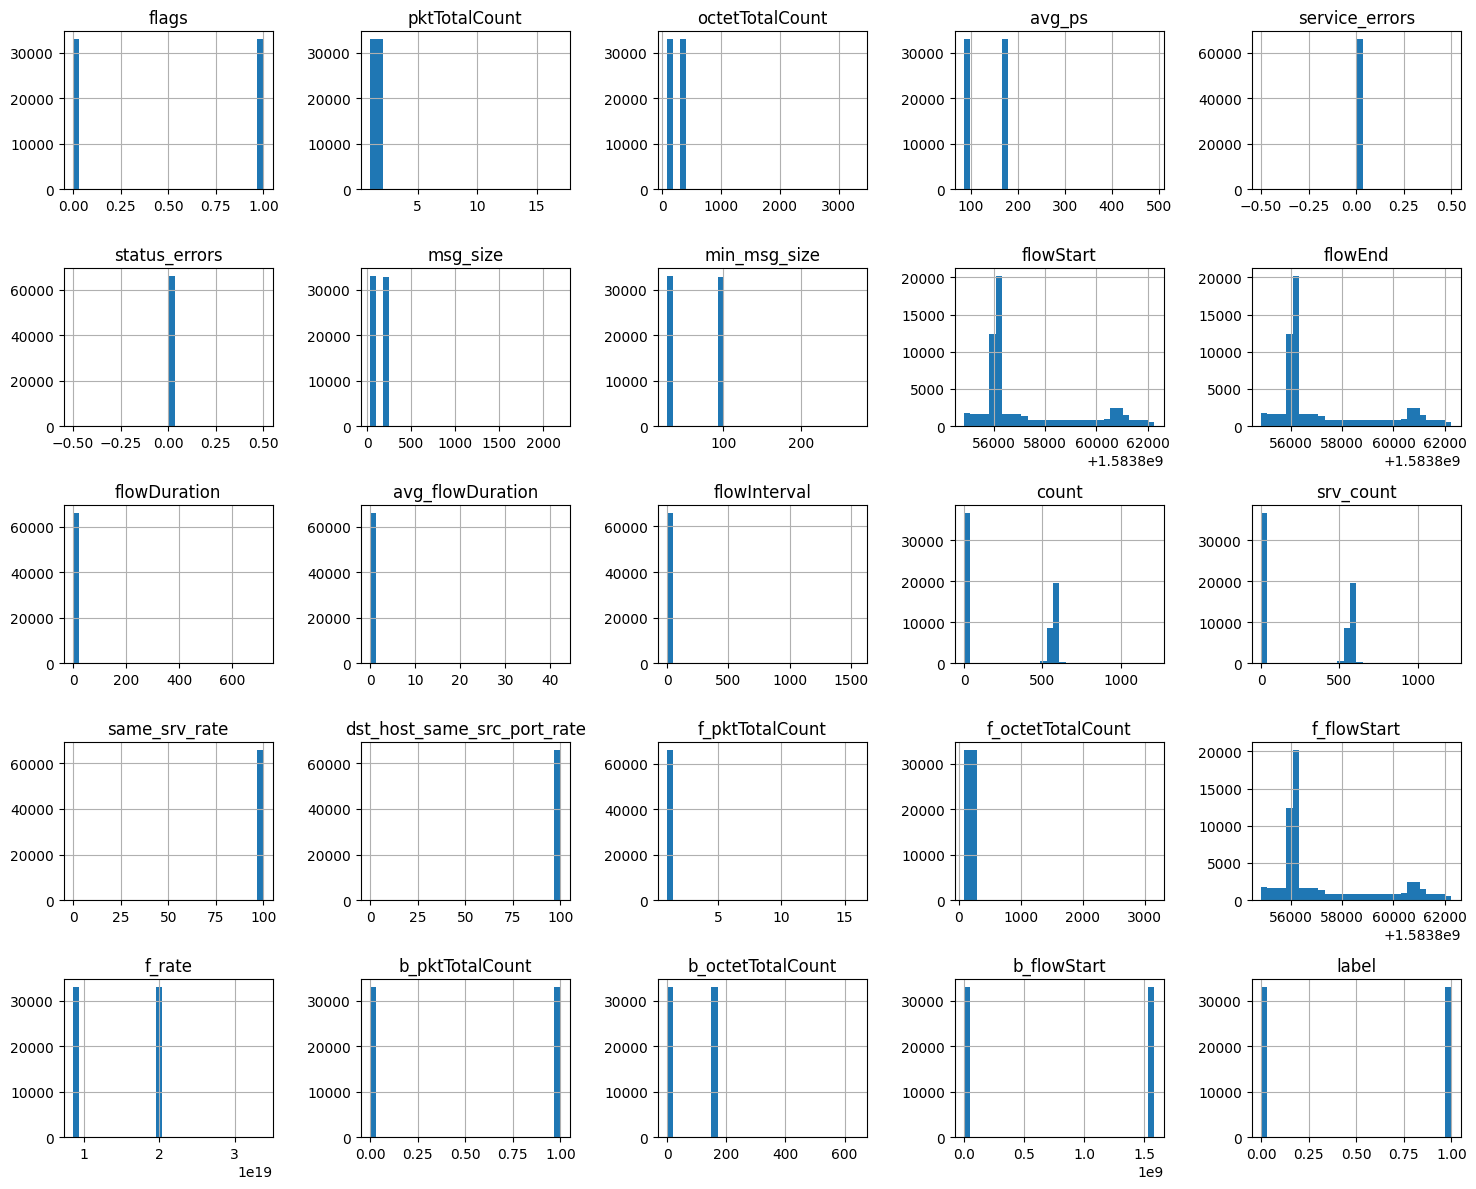

In [11]:
#checking distribution
import matplotlib.pyplot as plt

df.hist(bins=30, figsize=(15, 12))
plt.tight_layout()
plt.show()

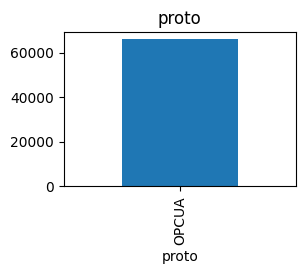

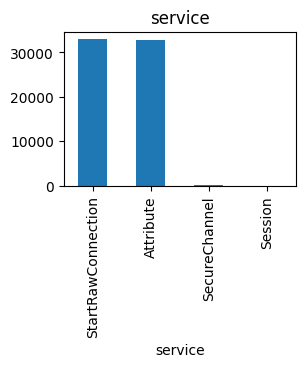

In [12]:
#Checking distribution of categorical features
categorical_cols = df.select_dtypes(include='object').columns

for col in categorical_cols:
    plt.figure(figsize = (3,2))
    df[col].value_counts().plot(kind='bar', title=col)
    plt.show()


In [13]:
#checking variance
df.var(numeric_only=True).sort_values()

service_errors                                                     0.0000
status_errors                                                      0.0000
f_pktTotalCount                                                    0.0034
avg_flowDuration                                                   0.0270
b_pktTotalCount                                                    0.2500
flags                                                              0.2500
label                                                              0.2500
pktTotalCount                                                      0.2536
flowDuration                                                       7.8067
same_srv_rate                                                     12.7376
dst_host_same_src_port_rate                                       12.9036
flowInterval                                                      39.3387
min_msg_size                                                    1023.7976
avg_ps                                

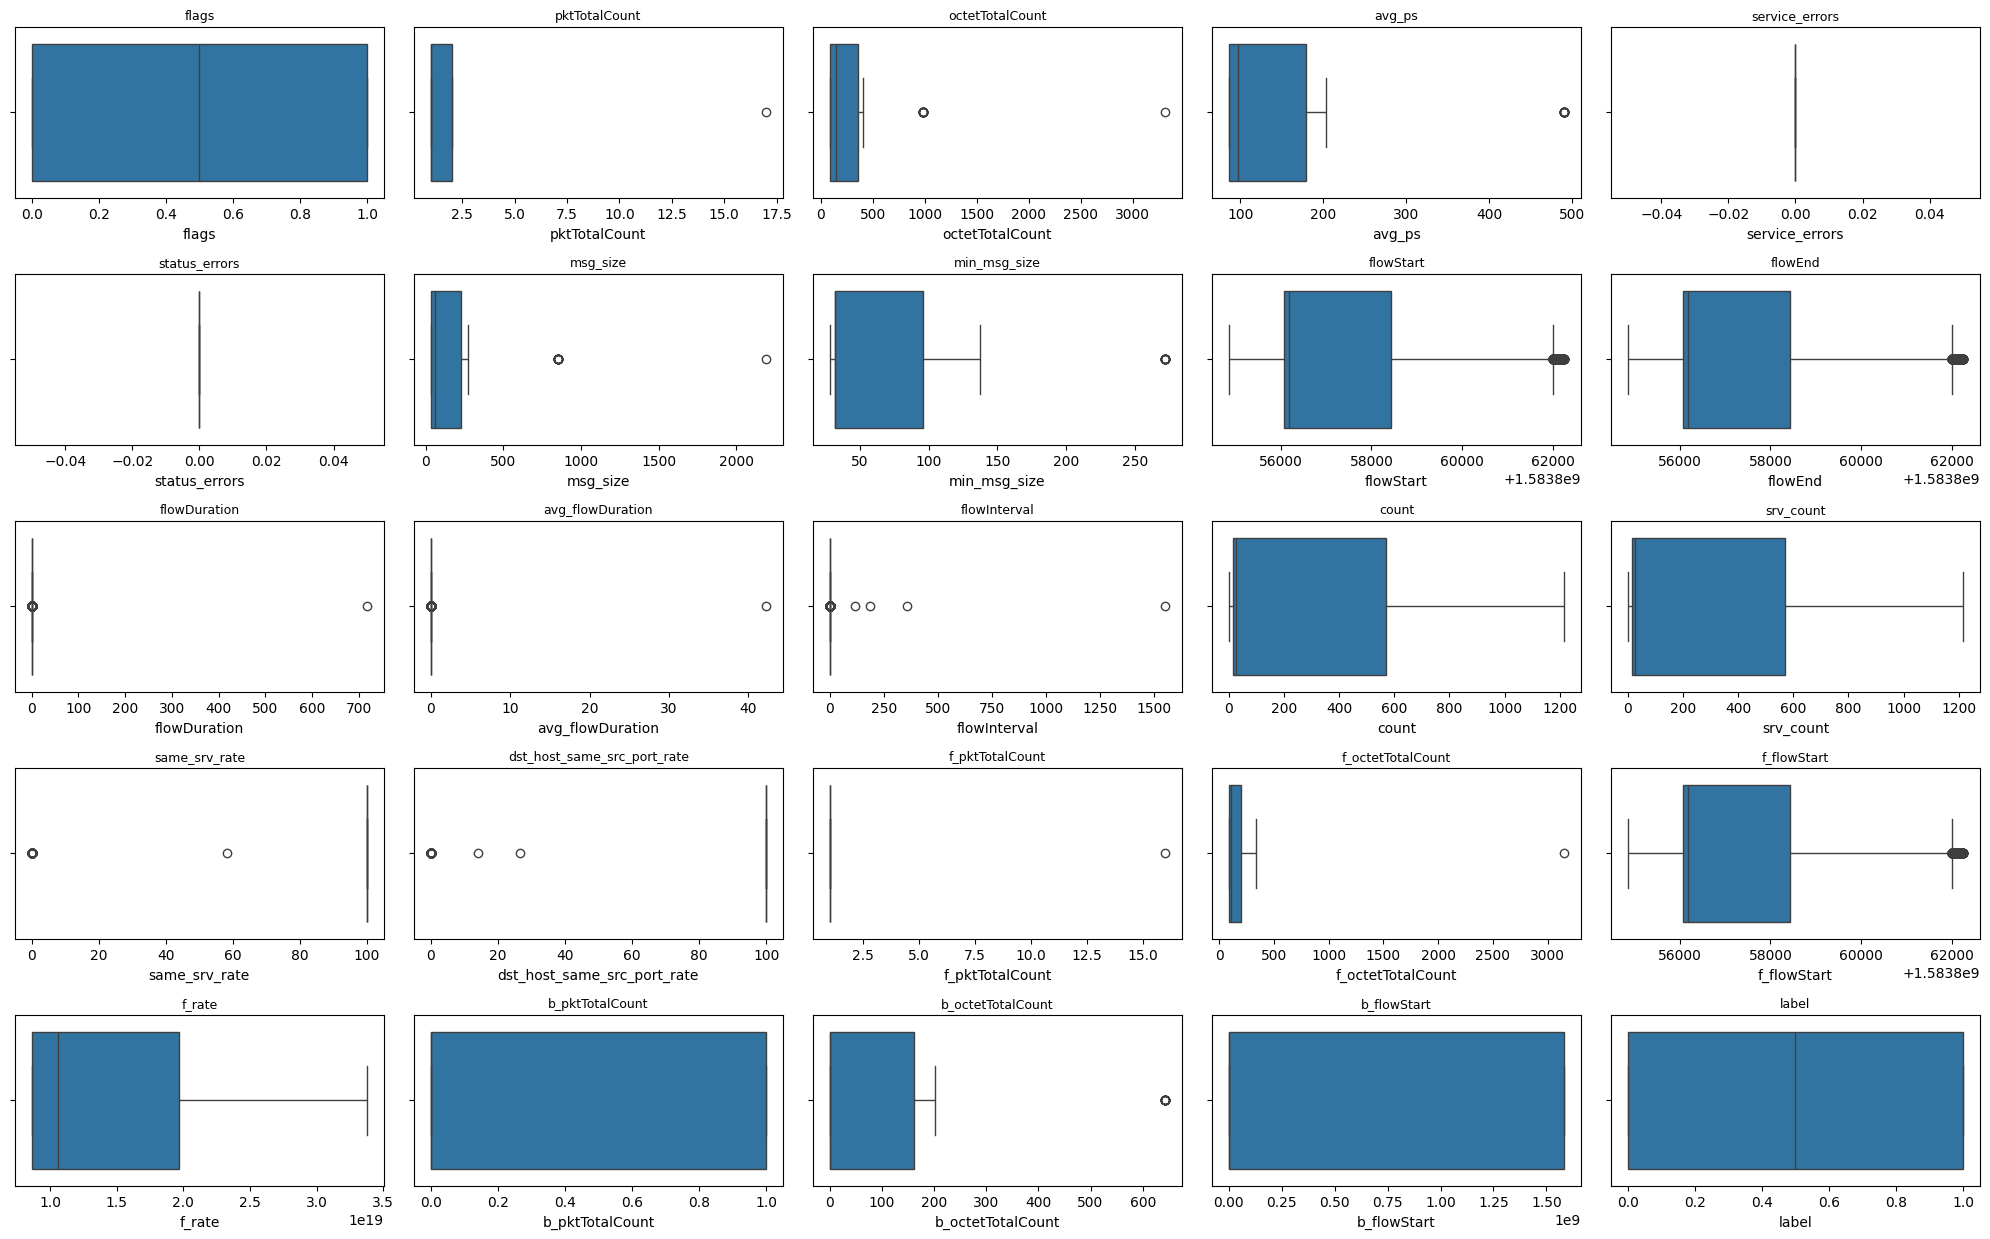

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = df.select_dtypes(include='number').columns
n_cols = 5
n_rows = -(-len(numeric_cols) // n_cols)

plt.figure(figsize=(n_cols * 4, n_rows * 2.5))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=df[col])
    plt.title(col, fontsize=9)
    plt.tight_layout()

plt.show()

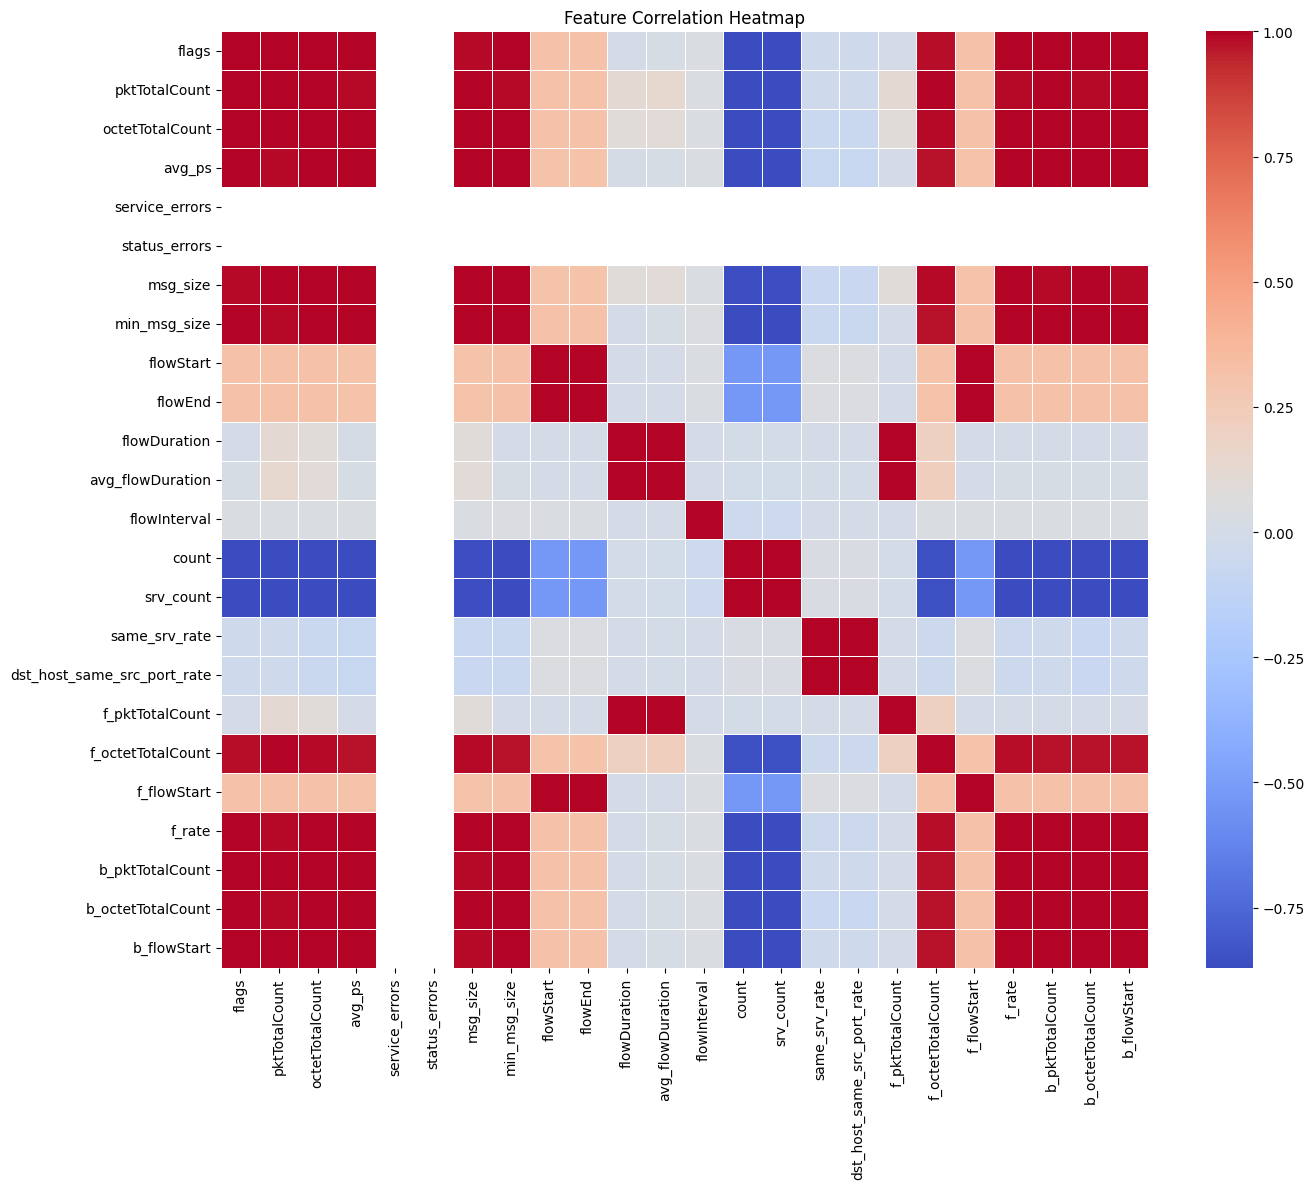

                              flags  pktTotalCount  octetTotalCount  avg_ps  \
flags                        1.0000         0.9929           0.9937  0.9942   
pktTotalCount                0.9929         1.0000           0.9967  0.9871   
octetTotalCount              0.9937         0.9967           1.0000  0.9958   
avg_ps                       0.9942         0.9871           0.9958  1.0000   
service_errors                  NaN            NaN              NaN     NaN   
status_errors                   NaN            NaN              NaN     NaN   
msg_size                     0.9916         0.9939           0.9996  0.9969   
min_msg_size                 0.9950         0.9874           0.9954  0.9995   
flowStart                    0.3172         0.3151           0.3137  0.3130   
flowEnd                      0.3172         0.3153           0.3139  0.3130   
flowDuration                 0.0054         0.1213           0.0892  0.0067   
avg_flowDuration             0.0170         0.1328  

In [15]:
corr_matrix = df.drop(columns=['label']).select_dtypes(include='number').corr().round(4)

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()
print(corr_matrix)

In [16]:
import numpy as np
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
dropped_features = [col for col in upper.columns if any(upper[col] > 0.95)]
df = df.drop(columns = dropped_features)
print("Dropped features due to high correlation:", dropped_features)

Dropped features due to high correlation: ['pktTotalCount', 'octetTotalCount', 'avg_ps', 'msg_size', 'min_msg_size', 'flowEnd', 'avg_flowDuration', 'srv_count', 'dst_host_same_src_port_rate', 'f_pktTotalCount', 'f_octetTotalCount', 'f_flowStart', 'f_rate', 'b_pktTotalCount', 'b_octetTotalCount', 'b_flowStart']


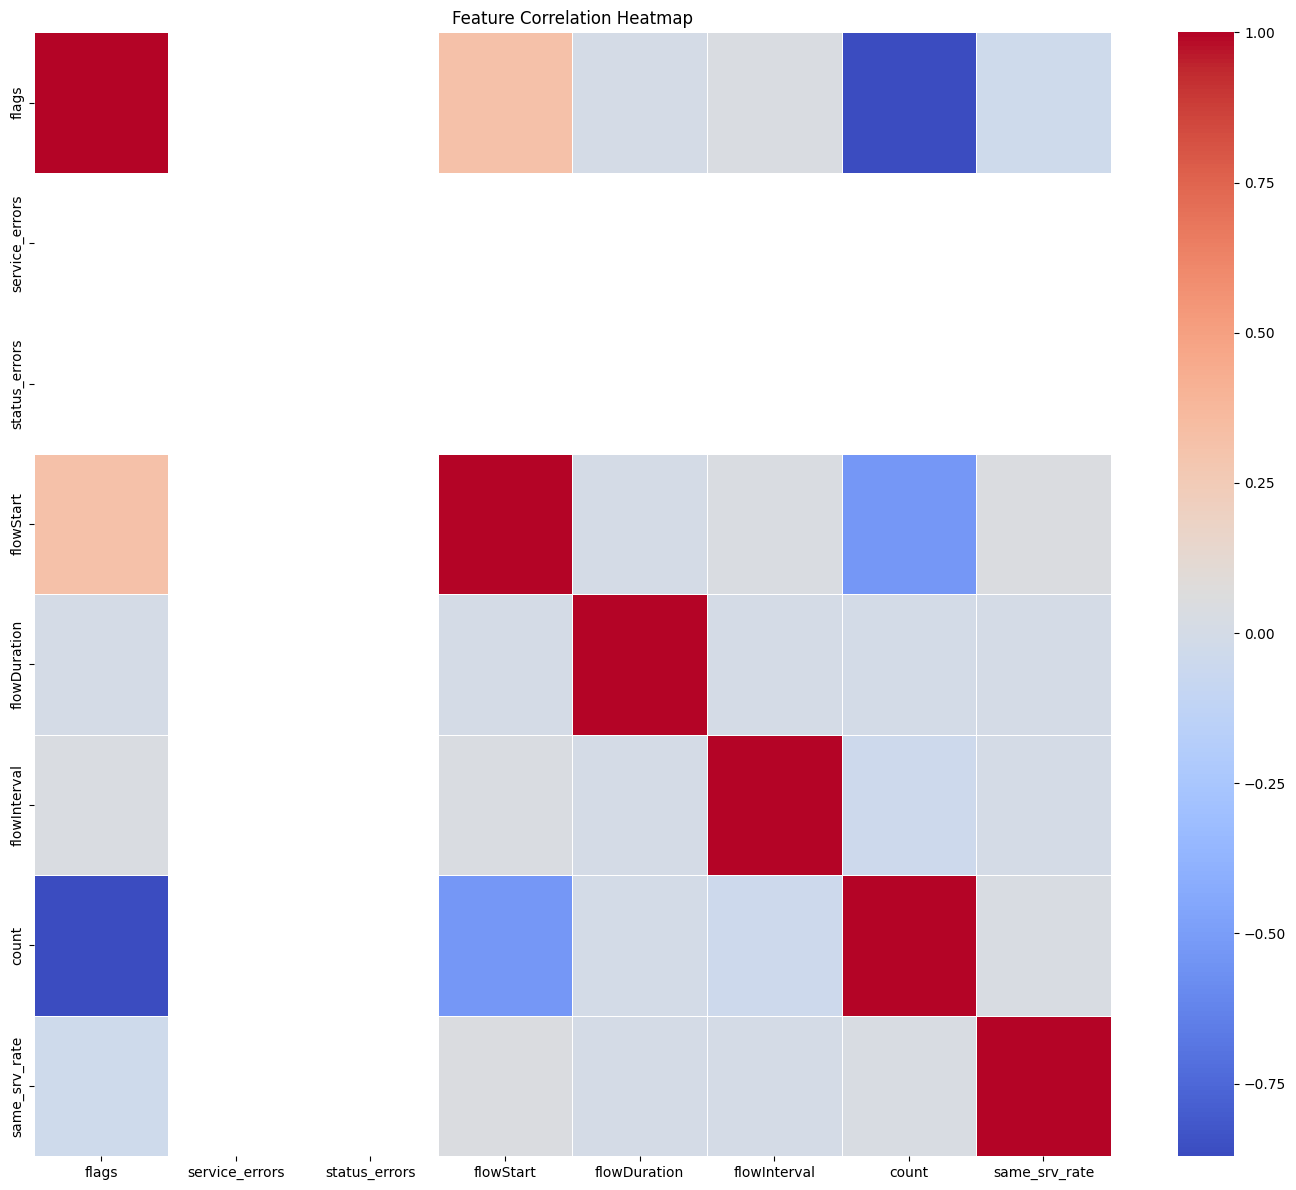

In [17]:
corr_matrix_updated = df.drop(columns=['label']).select_dtypes(include='number').corr().round(4)
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix_updated, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

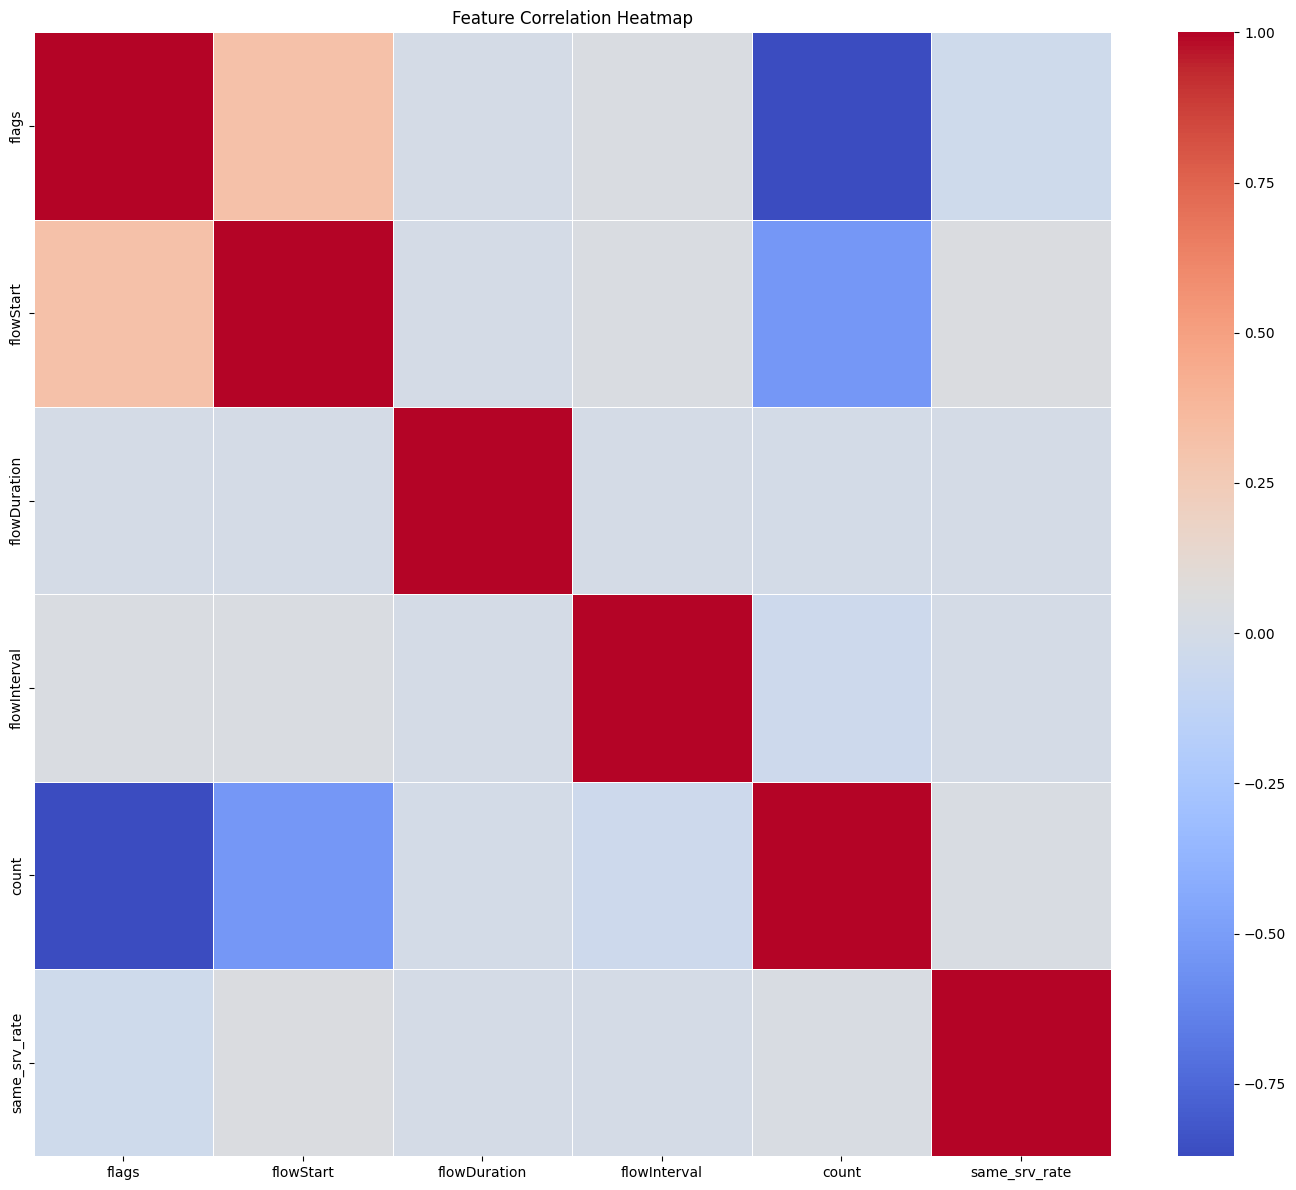

In [18]:
df = df.drop(['status_errors', 'service_errors'], axis = 1)
corr_matrix_updated2 = df.drop(columns=['label']).select_dtypes(include='number').corr().round(4)
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix_updated2, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

In [19]:
#Splitting data BEFORE further processing
from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 29)

In [20]:
#Building a pipeline for transformations and modeling
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

numerical_columns = [item for item in X_train.columns if item not in categorical_cols]

preprocessor = ColumnTransformer(transformers = [('object', OneHotEncoder(handle_unknown= 'ignore', sparse_output = False), categorical_cols),
                                                 ('numbers', StandardScaler(), numerical_columns)])

preprocessor1 = ColumnTransformer(transformers = [
                                                 ('numbers', StandardScaler(), numerical_columns)])
#Final parameters for RFC was determined after optimizing/testing
pipeline_RFC = Pipeline([
    ('preprocessor' , preprocessor1),
    ('classifier', RandomForestClassifier(n_estimators=12,
                                          max_depth=12,
                                          min_samples_split=10,
                                          min_samples_leaf=5,
                                          random_state=42
                                         ))
])

In [21]:
X_train_encoded = preprocessor.fit_transform(X_train)
encoded_feature_names = preprocessor.get_feature_names_out()
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
X_train_encoded_df['label'] = y_train

In [22]:
X_test_encoded = preprocessor.transform(X_test)
encoded_feature_names = preprocessor.get_feature_names_out()
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_feature_names, index=X_test.index)
X_test_encoded_df['label'] = y_test

In [23]:
correlations_with_label = X_train_encoded_df.corr(numeric_only=True)['label'].drop('label')
print(correlations_with_label)

object__proto_OPCUA                      NaN
object__service_Attribute            -0.9967
object__service_SecureChannel        -0.0285
object__service_Session              -0.0242
object__service_StartRawConnection    0.9995
numbers__flags                       -1.0000
numbers__flowStart                   -0.3159
numbers__flowDuration                -0.9356
numbers__flowInterval                -0.1164
numbers__count                        0.8704
numbers__same_srv_rate                0.0363
Name: label, dtype: float64


In [24]:
range1 = X_train_encoded_df.describe().loc[['min', 'max']].transpose().round(4)
print(range1)

                                        min      max
object__proto_OPCUA                  1.0000   1.0000
object__service_Attribute            0.0000   1.0000
object__service_SecureChannel        0.0000   1.0000
object__service_Session              0.0000   1.0000
object__service_StartRawConnection   0.0000   1.0000
numbers__flags                      -1.0021   0.9979
numbers__flowStart                  -1.2421   2.5438
numbers__flowDuration               -0.9375  13.3516
numbers__flowInterval               -0.1414 190.7503
numbers__count                      -0.9474   3.4384
numbers__same_srv_rate             -27.6095   0.0363
label                                0.0000   1.0000


In [25]:
cut_off = 0.90
high_corr_features = correlations_with_label[correlations_with_label.abs() > cut_off].index.tolist()
print(high_corr_features)
X_train_encoded_df = X_train_encoded_df.drop(columns = high_corr_features)
X_test_encoded_df = X_test_encoded_df.drop(columns = high_corr_features)

['object__service_Attribute', 'object__service_StartRawConnection', 'numbers__flags', 'numbers__flowDuration']


In [26]:
#Variance of feature 'proto' = 0, can safely drop 
X_train_encoded_df.drop(columns=['object__proto_OPCUA'])
X_test_encoded_df.drop(columns = ['object__proto_OPCUA'])

,object__service_SecureChannel,object__service_Session,numbers__flowStart,numbers__flowInterval,numbers__count,numbers__same_srv_rate,label
63423,0.0000,0.0000,-0.6280,-0.1396,1.0652,0.0363,1
43796,0.0000,0.0000,-0.5772,-0.1396,1.0976,0.0363,1
43886,0.0000,0.0000,-0.5959,-0.1397,1.0688,0.0363,1
14212,0.0000,0.0000,-0.5746,-0.1397,1.1193,0.0363,1
58735,0.0000,0.0000,-0.5956,0.1877,-0.8572,0.0363,0
...,...,...,...,...,...,...,...
53448,0.0000,0.0000,-0.5777,-0.1392,1.0976,0.0363,1
15877,0.0000,0.0000,1.7718,-0.1174,-0.8716,0.0363,0
57015,0.0000,0.0000,0.5175,-0.1303,-0.8861,0.0363,0
26146,0.0000,0.0000,1.7413,1.1142,-0.9402,0.0363,1


In [27]:
X_train_clean = X_train_encoded_df.drop(columns=['label'])
y_train = X_train_encoded_df['label']
X_test_clean = X_test_encoded_df.drop(columns=['label'])
y_test = X_test_encoded_df['label']

Training Models: 100%|██████████████████████████| 99/99 [02:29<00:00,  1.51s/it]


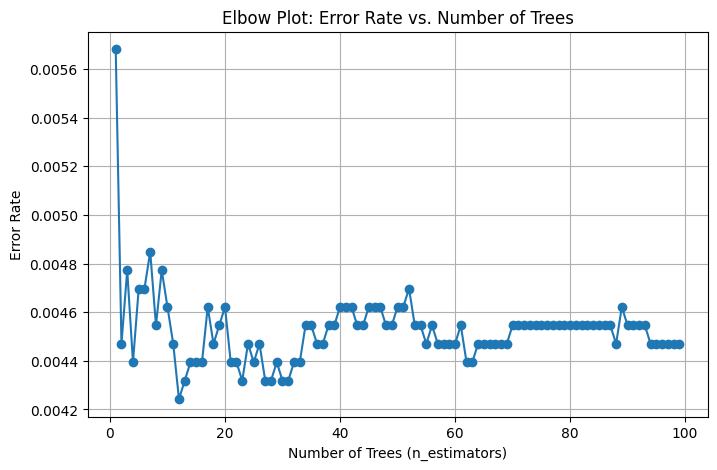

[0.9943181818181818, 0.995530303030303, 0.9952272727272727, 0.9956060606060606, 0.9953030303030304, 0.9953030303030304, 0.9951515151515151, 0.9954545454545455, 0.9952272727272727, 0.9953787878787879, 0.995530303030303, 0.9957575757575757, 0.9956818181818182, 0.9956060606060606, 0.9956060606060606, 0.9956060606060606, 0.9953787878787879, 0.995530303030303, 0.9954545454545455, 0.9953787878787879, 0.9956060606060606, 0.9956060606060606, 0.9956818181818182, 0.995530303030303, 0.9956060606060606, 0.995530303030303, 0.9956818181818182, 0.9956818181818182, 0.9956060606060606, 0.9956818181818182, 0.9956818181818182, 0.9956060606060606, 0.9956060606060606, 0.9954545454545455, 0.9954545454545455, 0.995530303030303, 0.995530303030303, 0.9954545454545455, 0.9954545454545455, 0.9953787878787879, 0.9953787878787879, 0.9953787878787879, 0.9954545454545455, 0.9954545454545455, 0.9953787878787879, 0.9953787878787879, 0.9953787878787879, 0.9954545454545455, 0.9954545454545455, 0.9953787878787879, 0.9953

In [28]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm
def elbow_plot(X_train_clean, y_train, X_test_clean, y_test):
    n_values = range(1, 100)
    error_rate = []
    accuracy_values = []

    for n in tqdm(n_values, desc="Training Models"):
        updated_model1 = RandomForestClassifier(
            n_estimators=n,
            max_depth=12,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=42
        )
        updated_model1.fit(X_train_clean, y_train)
        predictions = updated_model1.predict(X_test_clean)
        accuracy = accuracy_score(y_test, predictions)
        accuracy_values.append(accuracy)

    error_rate = [1.0 - acc for acc in accuracy_values]

    plt.figure(figsize=(8, 5))
    plt.plot(n_values, error_rate, marker='o', linestyle='-')
    plt.xlabel('Number of Trees (n_estimators)')
    plt.ylabel('Error Rate')
    plt.title('Elbow Plot: Error Rate vs. Number of Trees')
    plt.grid(True)
    plt.show()

    return accuracy_values

accuracy_plot = elbow_plot(X_train_clean, y_train, X_test_clean, y_test)
print(accuracy_plot)


Training Models: 100%|██████████████████████████| 12/12 [00:04<00:00,  2.64it/s]


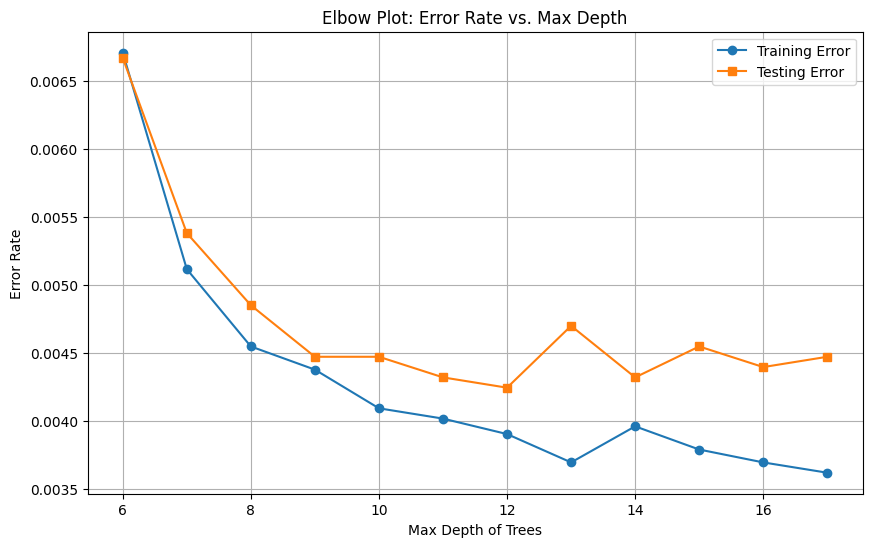

In [29]:
def elbow_plot(X_train_clean, y_train, X_test_clean, y_test):
    n_value = range(6, 18)
    error_rate_train = []
    error_rate_test = []
    accuracy_values_train = []
    accuracy_values_test = []

    for n in tqdm(n_value, desc="Training Models"):
        updated_model1 = RandomForestClassifier(
            n_estimators=12,
            max_depth=n,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=42
        )
        updated_model1.fit(X_train_clean, y_train)
        prediction_train = updated_model1.predict(X_train_clean)
        prediction_test = updated_model1.predict(X_test_clean)
        accuracy_train = accuracy_score(y_train, prediction_train)
        accuracy_test = accuracy_score(y_test, prediction_test)
        accuracy_values_train.append(accuracy_train)
        accuracy_values_test.append(accuracy_test)

    error_rate_train = [1.0 - acc for acc in accuracy_values_train]
    error_rate_test = [1.0 - acc for acc in accuracy_values_test]

    plt.figure(figsize=(10, 6))
    plt.plot(n_value, error_rate_train, label='Training Error', marker='o')
    plt.plot(n_value, error_rate_test, label='Testing Error', marker='s')
    plt.xlabel('Max Depth of Trees')
    plt.ylabel('Error Rate')
    plt.title('Elbow Plot: Error Rate vs. Max Depth')
    plt.legend()
    plt.grid(True)
    plt.show()

accuracy_plot = elbow_plot(X_train_clean, y_train, X_test_clean, y_test)

In [30]:
updated_model1 = RandomForestClassifier(n_estimators=12,
                                        max_depth=12,
                                        min_samples_split=10,
                                        min_samples_leaf=5,
                                        random_state=42
                                       )
updated_model1.fit(X_train_clean, y_train)
prediction_train = updated_model1.predict(X_train_clean)
prediction_test = updated_model1.predict(X_test_clean)
accuracy_train = accuracy_score(y_train, prediction_train)
accuracy_test = accuracy_score(y_test, prediction_test)

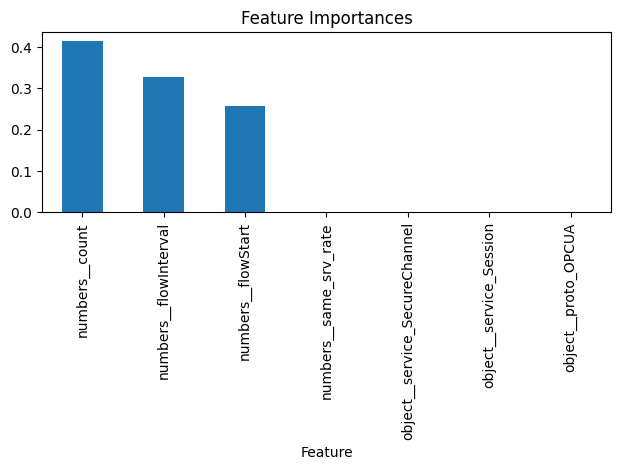

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

importances = updated_model1.feature_importances_
feature_names = X_train_clean.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False).plot(kind='bar', x='Feature', y='Importance', legend=False)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

In [32]:
#After further analysis, 4 more features can be reduced from the X_train raw data
print(X_train)

       flags  proto             service       flowStart  flowDuration  \
29094      0  OPCUA  StartRawConnection 1583856176.4262        0.0000   
64925      0  OPCUA  StartRawConnection 1583856225.4983        0.0000   
19937      1  OPCUA           Attribute 1583855703.0080        0.0082   
56583      1  OPCUA           Attribute 1583860669.2158        0.0079   
918        1  OPCUA           Attribute 1583858862.9004        0.0080   
...      ...    ...                 ...             ...           ...   
49393      0  OPCUA  StartRawConnection 1583856058.4859        0.0000   
52577      0  OPCUA  StartRawConnection 1583856140.0167        0.0000   
50072      0  OPCUA  StartRawConnection 1583856026.6342        0.0000   
60962      0  OPCUA  StartRawConnection 1583856200.3918        0.0000   
10749      0  OPCUA  StartRawConnection 1583856116.8671        0.0000   

       flowInterval  count  same_srv_rate  
29094        0.0033    582       100.0000  
64925        0.0038    572       10

In [33]:
#All values of 'service' are either too dominant causing overfitting or irrelevant, can drop entire feature
X_train = X_train.drop(columns = ['proto', 'same_srv_rate', 'flags', 'service', 'flowDuration'])
X_test = X_test.drop(columns = ['proto', 'same_srv_rate', 'flags', 'service', 'flowDuration'])

In [34]:
print(X_train)

            flowStart  flowInterval  count
29094 1583856176.4262        0.0033    582
64925 1583856225.4983        0.0038    572
19937 1583855703.0080        0.1879     21
56583 1583860669.2158        0.6995     27
918   1583858862.9004        0.1336     13
...               ...           ...    ...
49393 1583856058.4859        0.0036    569
52577 1583856140.0167        0.0034    569
50072 1583856026.6342        0.0035    577
60962 1583856200.3918        0.0034    580
10749 1583856116.8671        0.0050    574

[52800 rows x 3 columns]


In [35]:
print(X_train.columns)
print(pipeline_RFC)

Index(['flowStart', 'flowInterval', 'count'], dtype='object')
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numbers', StandardScaler(),
                                                  ['flags', 'flowStart',
                                                   'flowDuration',
                                                   'flowInterval', 'count',
                                                   'same_srv_rate'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=12, min_samples_leaf=5,
                                        min_samples_split=10, n_estimators=12,
                                        random_state=42))])


In [36]:
numerical_columns = ['flowStart', 'flowInterval', 'count']  # Match current data

preprocessor1 = ColumnTransformer(transformers=[
    ('numbers', StandardScaler(), numerical_columns)
])

pipeline_RFC = Pipeline([
    ('preprocessor', preprocessor1),
    ('classifier', RandomForestClassifier(
        n_estimators=12,
        max_depth=12,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    ))
])


In [37]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline_RFC, X_train, y_train, cv=5, scoring='accuracy')

print(f"CV Scores: {scores}")
print(f"Mean Accuracy: {scores.mean():.4f}")

CV Scores: [0.99535985 0.99526515 0.99498106 0.99498106 0.99583333]
Mean Accuracy: 0.9953


Train Accuracy: 0.9960
Test Accuracy: 0.9956


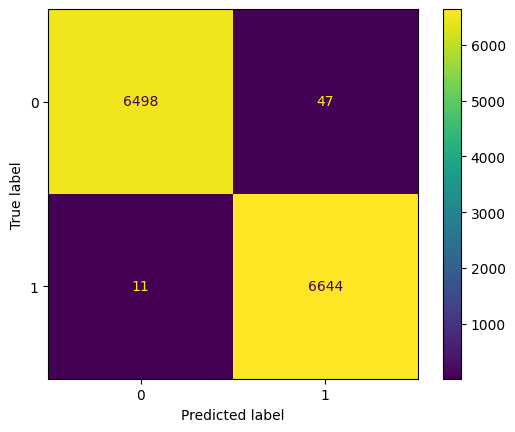

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pipeline_RFC.fit(X_train, y_train)
prediction_train = pipeline_RFC.predict(X_train)
prediction_test = pipeline_RFC.predict(X_test)
accuracy_train = accuracy_score(y_train, prediction_train)
accuracy_test = accuracy_score(y_test, prediction_test)
print(f"Train Accuracy: {accuracy_train:.4f}")
print(f"Test Accuracy: {accuracy_test:.4f}")
cm = confusion_matrix(y_test, prediction_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

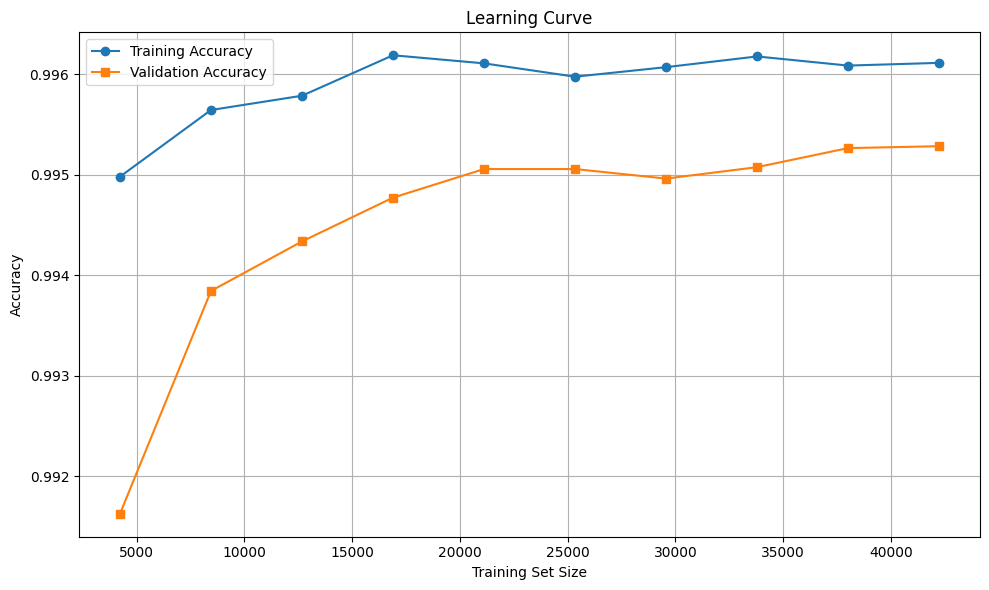

In [39]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipeline_RFC, X=X_train,
    y = y_train,
    cv = 5,
    train_sizes = np.linspace(0.1, 1.0, 10),
    scoring = 'accuracy',
    shuffle = True,
    random_state = 29
)
train_mean = train_scores.mean(axis = 1)
test_mean = test_scores.mean(axis = 1)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy', marker='o')
plt.plot(train_sizes, test_mean, label='Validation Accuracy', marker='s')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
updated_model1 = pipeline_RFC.fit(X_train, y_train)
prediction_train = updated_model1.predict(X_train)
prediction_test = updated_model1.predict(X_test)
accuracy_train = accuracy_score(y_train, prediction_train)
accuracy_test = accuracy_score(y_test, prediction_test)
print('Accuracy on train set: ', (round(accuracy_train, 5)))
print('Accuracy on test set: ', (round(accuracy_test, 5)))

Accuracy on train set:  0.99604
Accuracy on test set:  0.99561


In [41]:
#NEW MODEL NAME IS RandomForestModel1_proccessed
#This is for the model that is now correct, optimized, and not overfitted
#This model was made with preprocessed data

In [42]:
#DO NOT RUN

In [43]:
print(X_train)

            flowStart  flowInterval  count
29094 1583856176.4262        0.0033    582
64925 1583856225.4983        0.0038    572
19937 1583855703.0080        0.1879     21
56583 1583860669.2158        0.6995     27
918   1583858862.9004        0.1336     13
...               ...           ...    ...
49393 1583856058.4859        0.0036    569
52577 1583856140.0167        0.0034    569
50072 1583856026.6342        0.0035    577
60962 1583856200.3918        0.0034    580
10749 1583856116.8671        0.0050    574

[52800 rows x 3 columns]


In [44]:
#KNN

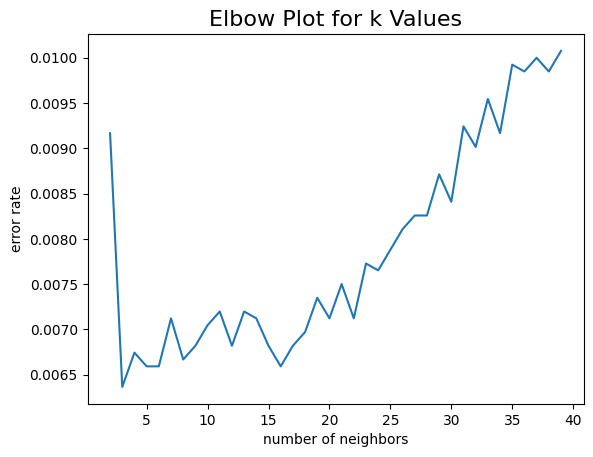

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(transformers = [
                                                 ('numbers', StandardScaler(), numerical_columns)])
pipeline_KNN = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])
k_vals = []
error_rates = []

for i in range(2, 40):
    pipeline_KNN.set_params(classifier__n_neighbors = i)
    pipeline_KNN.fit(X_train, y_train)
    error_rates.append(
        1 - accuracy_score(y_test, pipeline_KNN.predict(X_test))
    )
    k_vals.append(i)

plt.figure()
plt.title("Elbow Plot for k Values", fontsize=16)
plt.plot(k_vals, error_rates, linestyle='-')
plt.xlabel("number of neighbors")
plt.ylabel("error rate")
plt.show()


Text(0, 0.5, 'error rate')

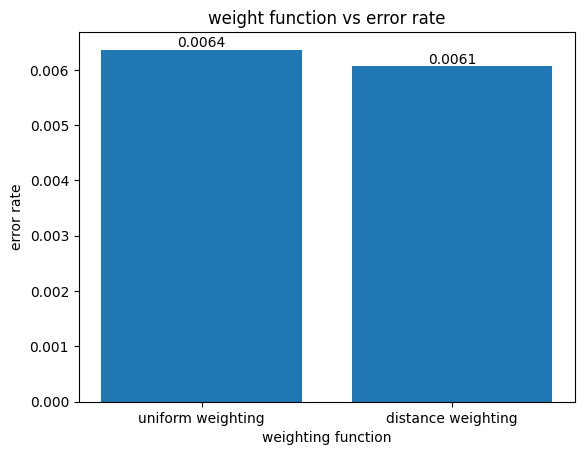

In [46]:
knn_uniform_weights = KNeighborsClassifier(n_neighbors=3, weights='uniform') #uniform is the default
knn_distance_weights = KNeighborsClassifier(n_neighbors=3, weights='distance')

knn_uniform_weights.fit(preprocessor.fit_transform(X_train), y_train)
knn_distance_weights.fit(preprocessor.fit_transform(X_train), y_train)

uniform_error = 1 - accuracy_score(y_test, knn_uniform_weights.predict(preprocessor.transform(X_test)))
distance_error = 1 - accuracy_score(y_test, knn_distance_weights.predict(preprocessor.transform(X_test)))

plt.figure()
plt.title("weight function vs error rate")
functions = ["uniform weighting", "distance weighting"]
counts = [uniform_error, distance_error]
for i, err in enumerate(counts):
    plt.text(i, err, f"{err:.4f}", ha='center', va='bottom')
plt.bar(functions, counts)
plt.ylim()
plt.grid(False)
plt.xlabel("weighting function")
plt.ylabel("error rate")

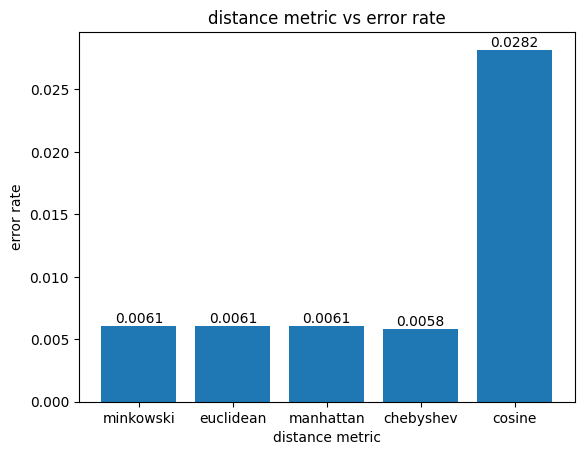

In [47]:
knn_minkowski = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='minkowski')
knn_euclidean = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='euclidean')
knn_manhattan = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='manhattan')
knn_chebyshev = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='chebyshev')
knn_cosine = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='cosine')

knn_minkowski.fit(preprocessor.fit_transform(X_train), y_train)
knn_euclidean.fit(preprocessor.fit_transform(X_train), y_train)
knn_manhattan.fit(preprocessor.fit_transform(X_train), y_train)
knn_chebyshev.fit(preprocessor.fit_transform(X_train), y_train)
knn_cosine.fit(preprocessor.fit_transform(X_train), y_train)

minkowski_error = 1 -accuracy_score(y_test, knn_minkowski.predict(preprocessor.transform(X_test)))
euclidean_error = 1 -accuracy_score(y_test, knn_euclidean.predict(preprocessor.transform(X_test)))
manhattan_error = 1 -accuracy_score(y_test, knn_manhattan.predict(preprocessor.transform(X_test)))
chebyshev_error =1 - accuracy_score(y_test, knn_chebyshev.predict(preprocessor.transform(X_test)))
cosine_error = 1 -accuracy_score(y_test, knn_cosine.predict(preprocessor.transform(X_test)))

plt.figure()
plt.title("distance metric vs error rate")
functions = ["minkowski", "euclidean", "manhattan", "chebyshev", "cosine"]
counts = [minkowski_error, euclidean_error, manhattan_error, chebyshev_error, cosine_error]
for i, err in enumerate(counts):
    plt.text(i, err, f"{err:.4f}", ha='center', va='bottom')
plt.bar(functions, counts)
plt.ylim()
plt.xlabel("distance metric")
plt.ylabel("error rate")
plt.show()

In [84]:
pipeline_KNN = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=3, weights='distance', metric='chebyshev'))
])

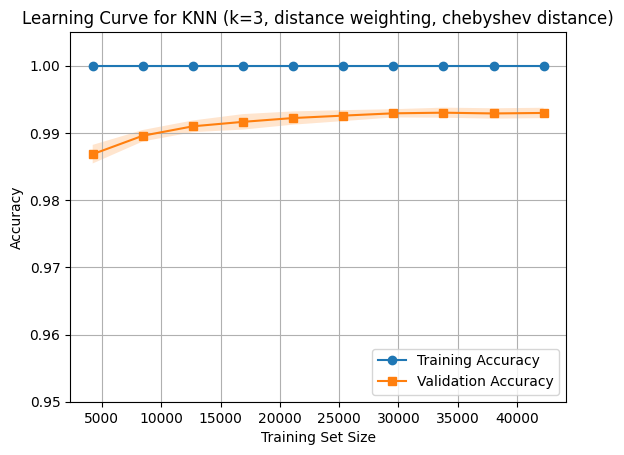

In [68]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='chebyshev')

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=knn,
    X=(preprocessor.fit_transform(X_train)),
    y=y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1, 10),
    shuffle=True,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(validation_scores, axis=1)
val_std = np.std(validation_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, label='Training Accuracy', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, val_mean, label='Validation Accuracy', marker='s')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.title("Learning Curve for KNN (k=3, distance weighting, chebyshev distance)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.grid(True)
plt.ylim(0.95, 1.005)
plt.show()

In [49]:
#logistic regression

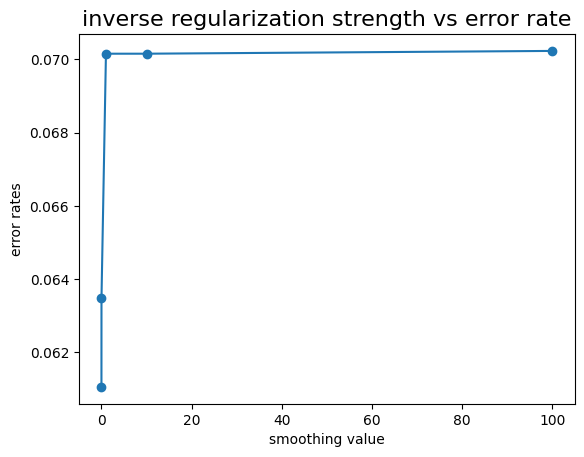

In [50]:
from sklearn.linear_model import LogisticRegression

reg_strength = [0.001, 0.01, 1, 10, 100]
error_rates = []

for i in reg_strength:
    lr = LogisticRegression(C=i)
    lr.fit((preprocessor.fit_transform(X_train)), y_train)
    error_rates.append(
        1 - accuracy_score(y_test, lr.predict((preprocessor.transform(X_test)))
    ))

plt.figure()
plt.title("inverse regularization strength vs error rate", fontsize=16)
plt.plot(reg_strength, error_rates, linestyle='-', marker='o')
plt.xlabel("smoothing value")
plt.ylabel("error rates")
plt.show()

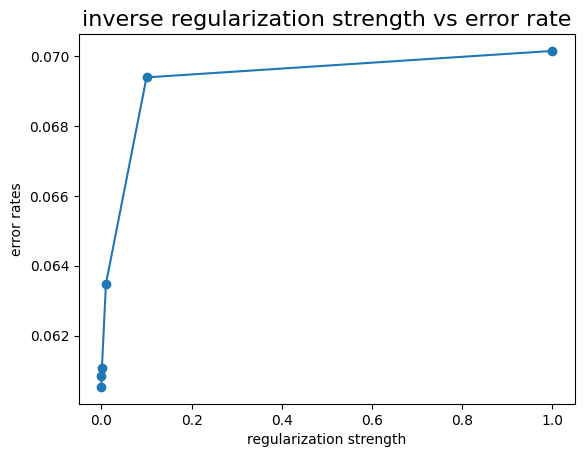

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1]
[0.060530303030303045, 0.060833333333333295, 0.06106060606060604, 0.06348484848484848, 0.06939393939393934, 0.07015151515151519]


In [51]:
reg_strength = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1]
error_rates = []

for i in reg_strength:
    lr = LogisticRegression(C=i)
    lr.fit((preprocessor.fit_transform(X_train)), y_train)
    error_rates.append(
        1 - accuracy_score(y_test, lr.predict((preprocessor.transform(X_test))
    )))

plt.figure()
plt.title("inverse regularization strength vs error rate", fontsize=16)
plt.plot(reg_strength, error_rates, linestyle='-', marker='o')
plt.xlabel("regularization strength")
plt.ylabel("error rates")
plt.show()

print(reg_strength)
print(error_rates)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


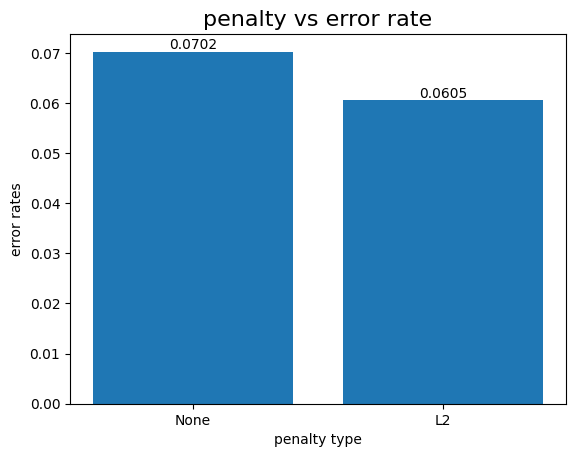

[None, 'l2']
[0.0702272727272727, 0.060530303030303045]


In [52]:
penalty_type = [None, 'l2']
error_rates = []

for i in penalty_type:
    lr = LogisticRegression(C=1e-5, penalty=i)
    lr.fit((preprocessor.fit_transform(X_train)), y_train)
    error_rates.append(
        1 - accuracy_score(y_test, lr.predict((preprocessor.transform(X_test))
    )))

plt.figure()
plt.title("penalty vs error rate", fontsize=16)
plt.bar(["None", "L2"], error_rates)
plt.xlabel("penalty type")
for i, err in enumerate(error_rates):
    plt.text(i, err, f"{err:.4f}", ha='center', va='bottom')
plt.ylabel("error rates")
plt.show()

print(penalty_type)
print(error_rates)

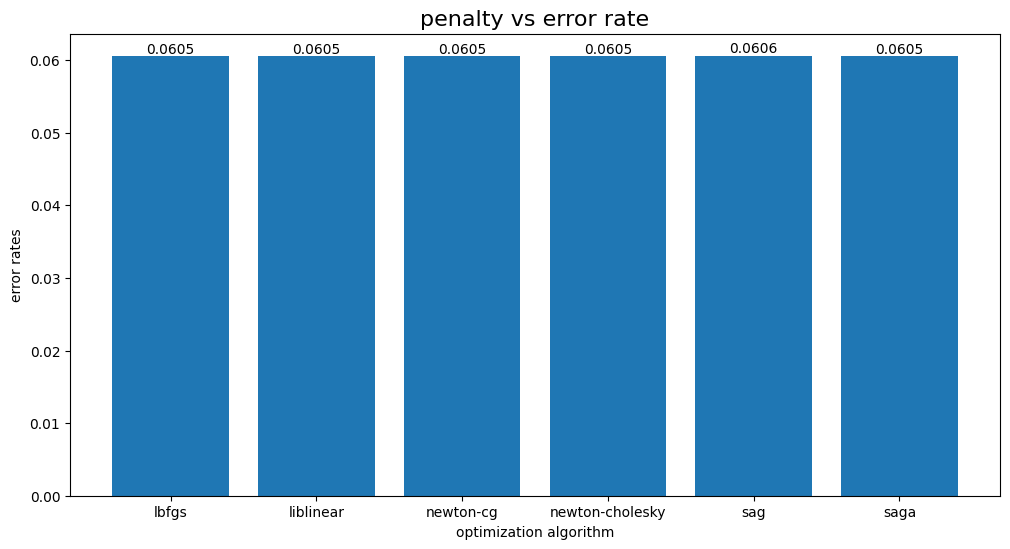

['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
[0.060530303030303045, 0.060530303030303045, 0.060530303030303045, 0.060530303030303045, 0.06060606060606055, 0.060530303030303045]


In [53]:
optim_alg = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
error_rates = []

for i in optim_alg:
    lr = LogisticRegression(C=1e-5, penalty='l2', solver=i)
    lr.fit((preprocessor.fit_transform(X_train)), y_train)
    error_rates.append(
        1 - accuracy_score(y_test, lr.predict(((preprocessor.transform(X_test))
    ))))

plt.figure(figsize=(12, 6))
plt.title("penalty vs error rate", fontsize=16)
plt.bar(optim_alg, error_rates)
plt.xlabel("optimization algorithm")
for i, err in enumerate(error_rates):
    plt.text(i, err, f"{err:.4f}", ha='center', va='bottom')
plt.ylabel("error rates")
plt.show()

print(optim_alg)
print(error_rates)

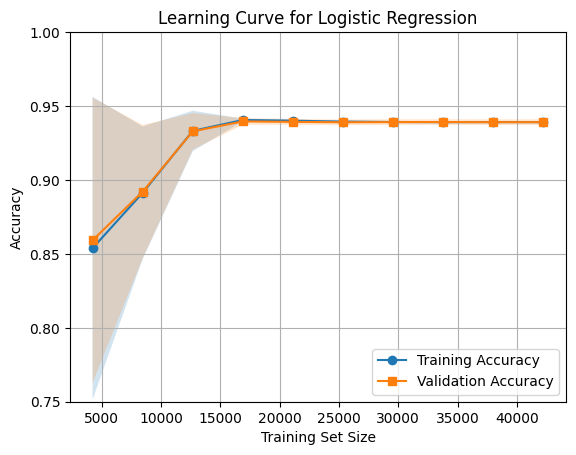

In [54]:
preprocessor = ColumnTransformer(transformers = [
                                                 ('numbers', StandardScaler(), numerical_columns)])
pipeline_LR = Pipeline([
    ('scaler',preprocessor),
    ('classifier', LogisticRegression(C=1e-5, penalty='l2', solver='lbfgs'))
])
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=pipeline_LR,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1, 10),
    shuffle=True,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(validation_scores, axis=1)
val_std = np.std(validation_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, label='Training Accuracy', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, val_mean, label='Validation Accuracy', marker='s')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.title("Learning Curve for Logistic Regression")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.ylim(0.75, 1)
plt.grid(True)
plt.show()

In [55]:
#Stochastic Gradient Descent

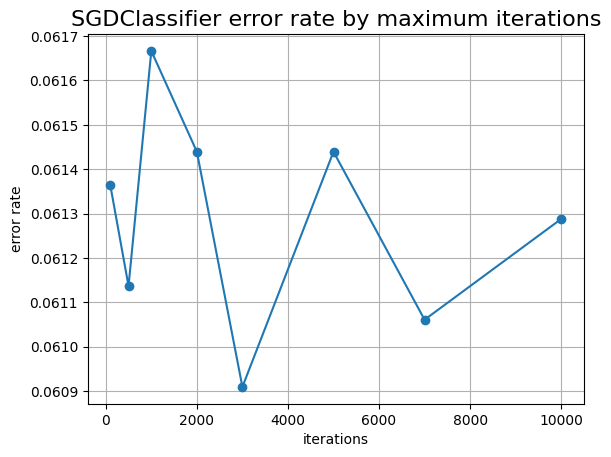

In [56]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train_clean_std_scaled = scaler.fit_transform(X_train)
X_test_clean_std_scaled = scaler.transform(X_test)

iteration_values = [100, 500, 1000, 2000, 3000, 5000, 7000, 10000]
error_rates = []

for i in iteration_values:
    sd = SGDClassifier(max_iter=i,)
    sd.fit(X_train_clean_std_scaled, y_train)
    error_rates.append(
        1 - accuracy_score(y_test, sd.predict(X_test_clean_std_scaled))
    )


plt.figure()
plt.title("SGDClassifier error rate by maximum iterations", fontsize=16)
plt.plot(iteration_values, error_rates, linestyle='-', marker='o')
plt.xlabel("iterations")
plt.ylabel("error rate")
plt.ylim()
plt.grid(True)
plt.show()

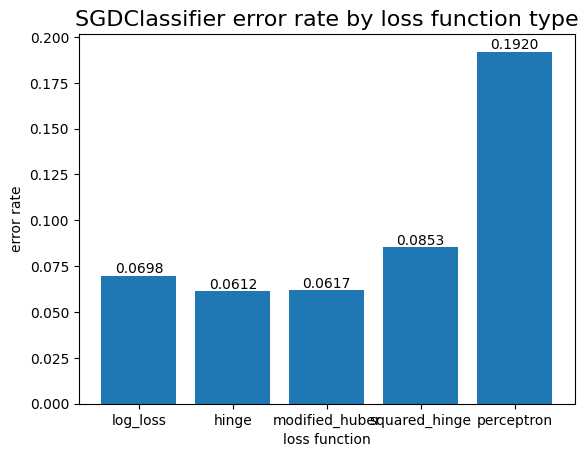

In [57]:
loss_functions = ['log_loss', 'hinge', 'modified_huber', 'squared_hinge', 'perceptron']
error_rates = []

for i in loss_functions:
    sd = SGDClassifier(max_iter=100, loss=i)
    sd.fit(X_train_clean_std_scaled, y_train)
    error_rates.append(
        1 - accuracy_score(y_test, sd.predict(X_test_clean_std_scaled))
    )


plt.figure()
plt.title("SGDClassifier error rate by loss function type", fontsize=16)
for i, err in enumerate(error_rates):
    plt.text(i, err, f"{err:.4f}", ha='center', va='bottom')
plt.bar(loss_functions, error_rates)
plt.xlabel("loss function")
plt.ylabel("error rate")
plt.ylim()
plt.grid(False)
plt.show()

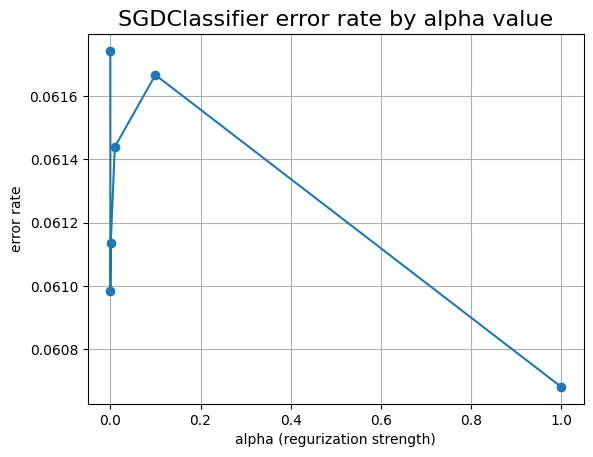

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1]
[0.061742424242424265, 0.06098484848484853, 0.061136363636363655, 0.061439393939393905, 0.06166666666666665, 0.06068181818181817]


In [58]:
reg_parameters = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
error_rates = []
for i in reg_parameters:
    sd = SGDClassifier(max_iter=100, loss='hinge', alpha=i)
    sd.fit(X_train_clean_std_scaled, y_train)
    error_rates.append(
        1 - accuracy_score(y_test, sd.predict(X_test_clean_std_scaled))
    )


plt.figure()
plt.title("SGDClassifier error rate by alpha value", fontsize=16)
plt.plot(reg_parameters, error_rates, linestyle='-', marker='o')
plt.xlabel("alpha (regurization strength)")
plt.ylabel("error rate")
plt.ylim()
plt.grid(True)
plt.show()
print(reg_parameters)
print(error_rates)

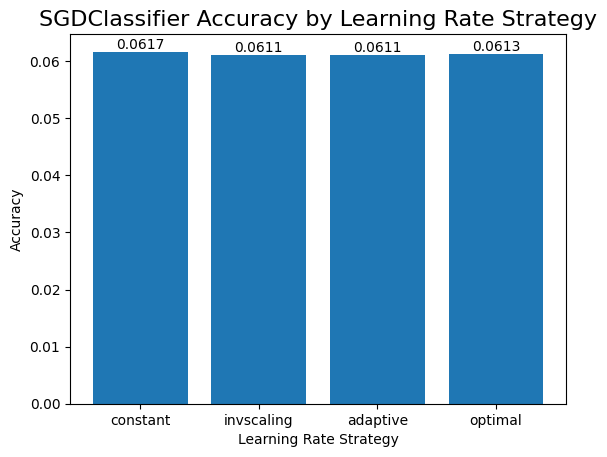

error rates: [0.06166666666666665, 0.061136363636363655, 0.061136363636363655, 0.06128787878787878]


In [59]:
learning_rates = ['constant', 'invscaling', 'adaptive', 'optimal']
error_rates = []

for i in learning_rates:
    sd = SGDClassifier(max_iter=100, loss='hinge', learning_rate=i, eta0=0.1)
    sd.fit(X_train_clean_std_scaled, y_train)
    err = 1 - accuracy_score(y_test, sd.predict(X_test_clean_std_scaled))
    error_rates.append(err)

plt.figure()
plt.title("SGDClassifier Accuracy by Learning Rate Strategy", fontsize=16)
plt.bar(learning_rates, error_rates)
for i, err in enumerate(error_rates):
    plt.text(i, err, f"{err:.4f}", ha='center', va='bottom')
plt.xlabel("Learning Rate Strategy")
plt.ylabel("Accuracy")
plt.ylim()
plt.grid(False)
plt.show()

print("error rates:", error_rates)

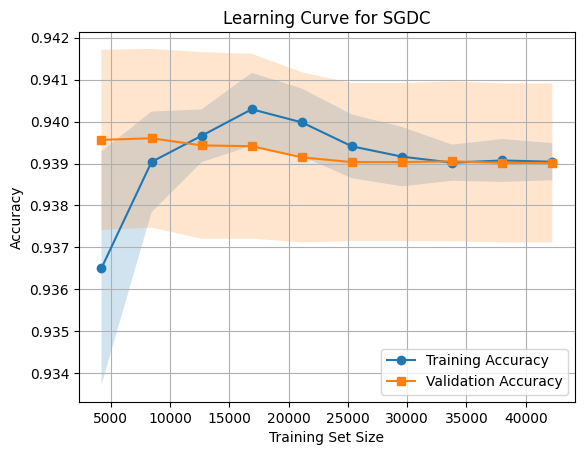

In [60]:
pipeline_SD = Pipeline([
    ('preprocessor', StandardScaler()),
    ('classifier', SGDClassifier(loss='log_loss', max_iter=100, alpha=1, learning_rate='adaptive', eta0=0.1)
    )])

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=pipeline_SD,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1, 10),
    shuffle=True,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(validation_scores, axis=1)
val_std = np.std(validation_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, label='Training Accuracy', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, val_mean, label='Validation Accuracy', marker='s')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.title("Learning Curve for SGDC")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.grid(True)
plt.ylim()
plt.show()

In [61]:
#STUFF BELOW THIS NEEDS EDITING AND ORGANIZING 

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

cv = cross_validate(pipeline_RFC, 
                    X_train, 
                    y_train, 
                    cv = 5, 
                    scoring = ['accuracy', 'precision', 'recall', 'f1'],
                    return_train_score = True)
print(pd.DataFrame(cv))

   fit_time  score_time  test_accuracy  train_accuracy  test_precision  \
0    0.3308      0.0182         0.9954          0.9961          0.9939   
1    0.2746      0.0175         0.9953          0.9959          0.9926   
2    0.2633      0.0170         0.9950          0.9963          0.9934   
3    0.2735      0.0178         0.9950          0.9961          0.9923   
4    0.2838      0.0173         0.9958          0.9959          0.9941   

   train_precision  test_recall  train_recall  test_f1  train_f1  
0           0.9943       0.9968        0.9979   0.9954    0.9961  
1           0.9937       0.9979        0.9981   0.9953    0.9959  
2           0.9942       0.9966        0.9983   0.9950    0.9963  
3           0.9943       0.9977        0.9979   0.9950    0.9961  
4           0.9938       0.9975        0.9980   0.9958    0.9959  


In [ ]:
print(cv['test_accuracy'])

[0.99535985 0.99526515 0.99498106 0.99498106 0.99583333]


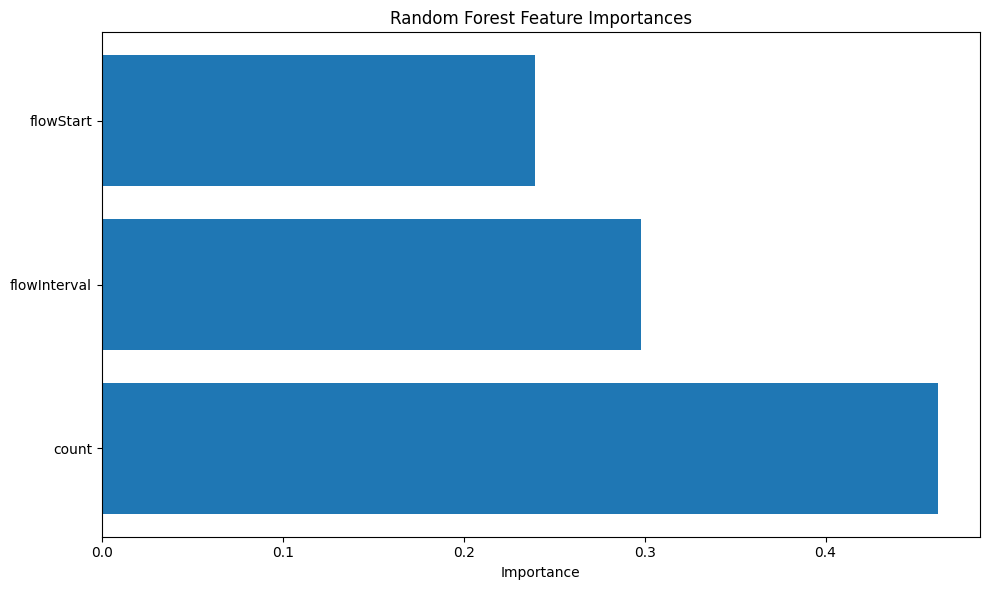

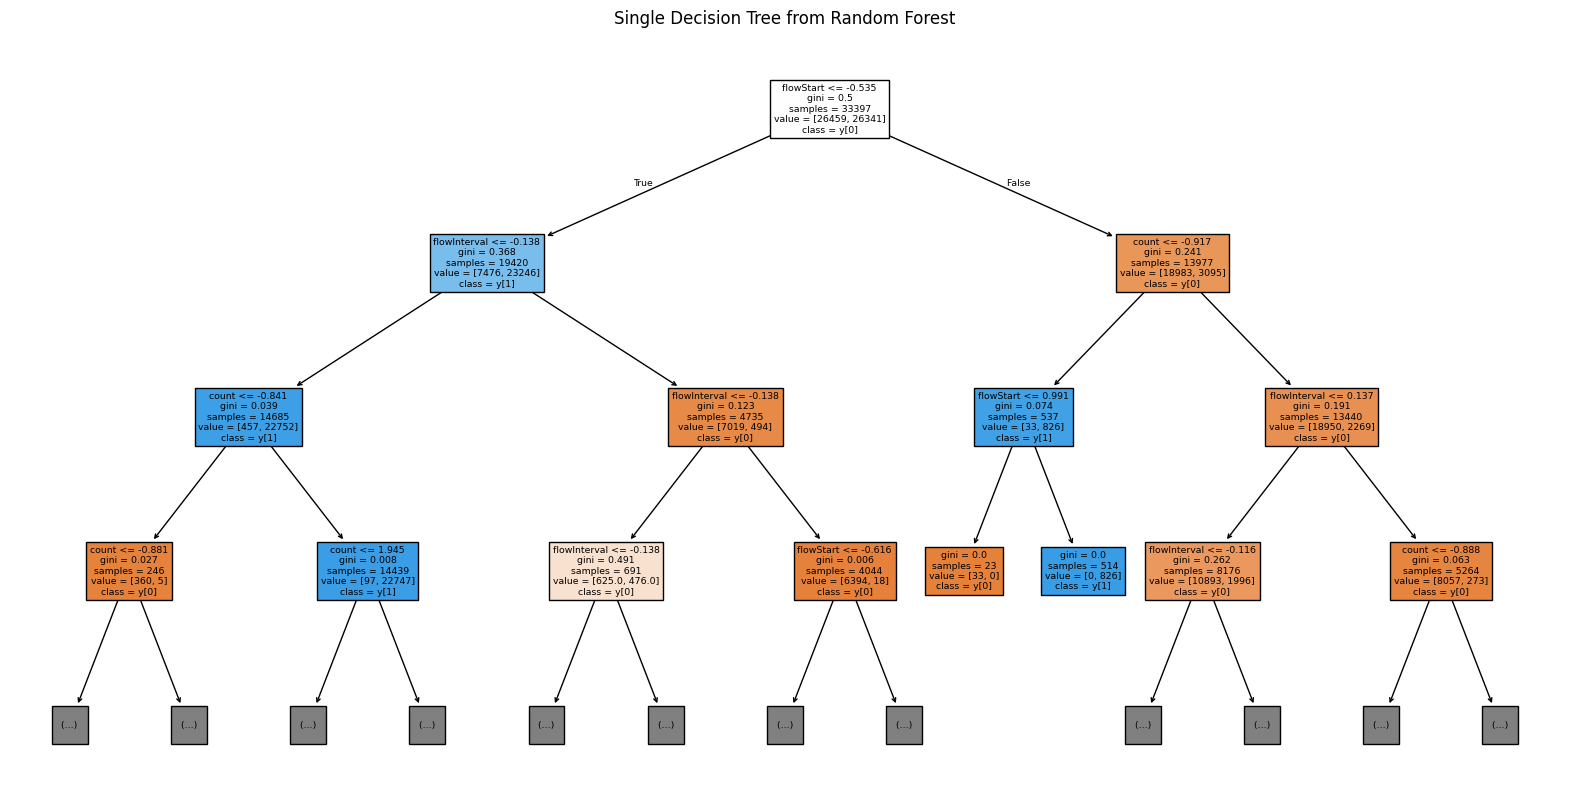

In [146]:
from sklearn.tree import plot_tree

rf = pipeline_RFC.named_steps['classifier']

importances = rf.feature_importances_
feature_names = X_train.columns

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Importance")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
#plt.grid(True)
plt.tight_layout()
plt.show()

tree = rf.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=X_train.columns, class_names=True, filled=True, max_depth=3)
plt.title("Single Decision Tree from Random Forest")
plt.show()


In [85]:
from sklearn.model_selection import cross_validate

cv = cross_validate(pipeline_KNN, 
                    X_train, 
                    y_train, 
                    cv = 5, scoring = ['accuracy', 'precision', 'recall', 'f1'],
                    return_train_score = True)
print(pd.DataFrame(cv))


   fit_time  score_time  test_accuracy  train_accuracy  test_precision  \
0    0.0260      0.0329         0.9933          1.0000          0.9917   
1    0.0181      0.0301         0.9922          1.0000          0.9904   
2    0.0177      0.0298         0.9933          1.0000          0.9924   
3    0.0176      0.0299         0.9920          1.0000          0.9885   
4    0.0180      0.0300         0.9938          1.0000          0.9924   

   train_precision  test_recall  train_recall  test_f1  train_f1  
0           1.0000       0.9949        1.0000   0.9933    1.0000  
1           1.0000       0.9941        1.0000   0.9922    1.0000  
2           1.0000       0.9941        1.0000   0.9933    1.0000  
3           1.0000       0.9954        1.0000   0.9920    1.0000  
4           1.0000       0.9953        1.0000   0.9938    1.0000  


In [147]:
print(cv['test_accuracy'])

[0.99327652 0.99223485 0.99327652 0.99195076 0.9938447 ]


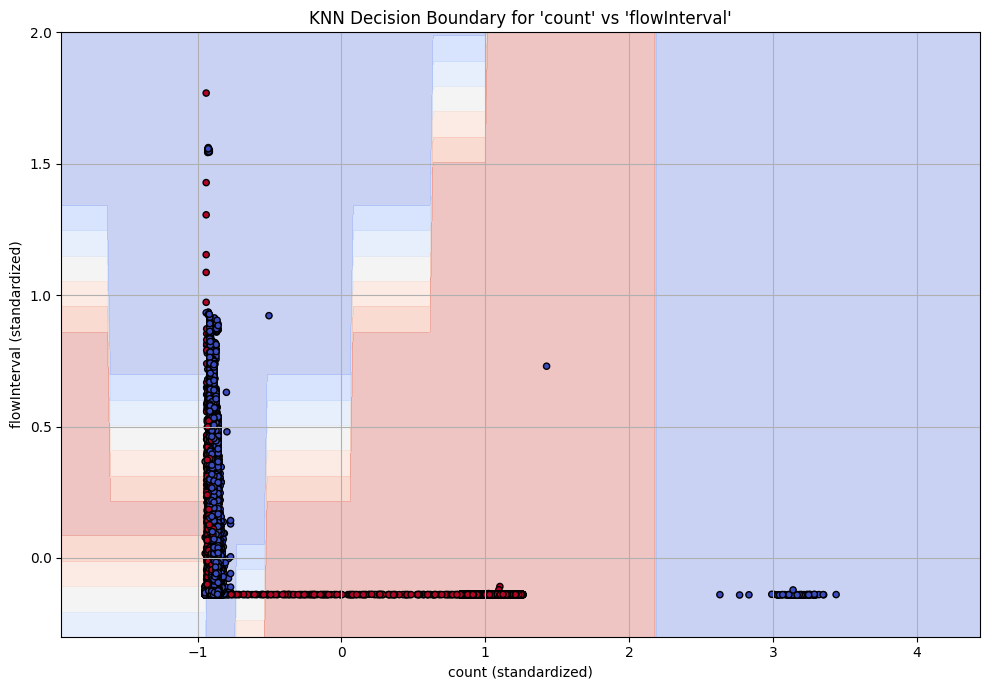

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

features = ['count', 'flowInterval']
X_vis = X_train[features]
y_vis = y_train

scaler = StandardScaler()
pipeline_vis = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', scaler, features)
    ])),
    ('classifier', KNeighborsClassifier(n_neighbors=3, weights='distance', metric='chebyshev'))
])
pipeline_vis.fit(X_vis, y_vis)

X_scaled = scaler.fit_transform(X_vis)
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

grid_scaled = np.c_[xx.ravel(), yy.ravel()]
grid_df = pd.DataFrame(scaler.inverse_transform(grid_scaled), columns=features)

Z = pipeline_vis.predict(grid_df)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

mask = X_scaled[:, 1] < 5
plt.scatter(X_scaled[mask, 0], X_scaled[mask, 1], c=y_vis[mask], cmap='coolwarm', edgecolor='k', s=20)

plt.title(f"KNN Decision Boundary for 'count' vs 'flowInterval'")
plt.xlabel('count (standardized)')
plt.ylabel('flowInterval (standardized)')
plt.ylim(-0.3, 2)
plt.grid(True)
plt.tight_layout()
plt.show()



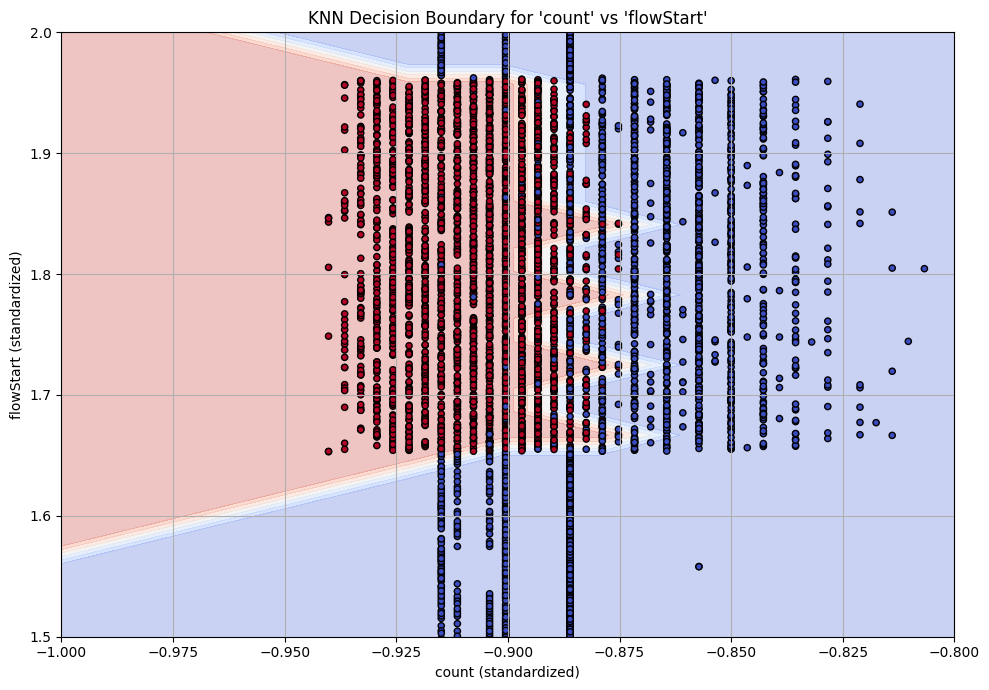

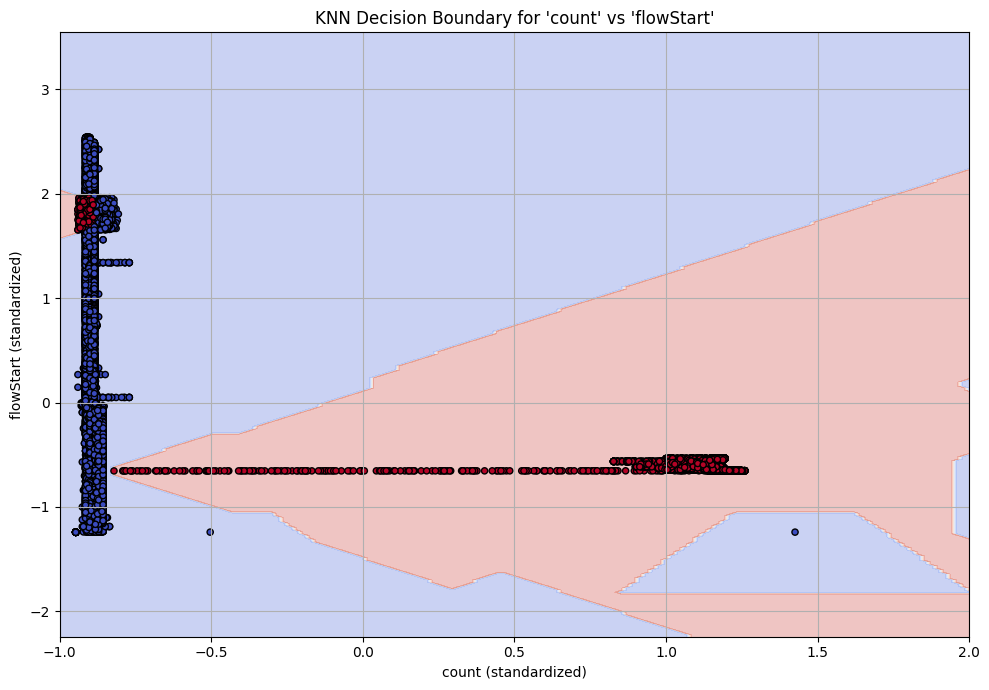

In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

features = ['count', 'flowStart']
X_vis = X_train[features]
y_vis = y_train

scaler = StandardScaler()
pipeline_vis = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', scaler, features)
    ])),
    ('classifier', KNeighborsClassifier(n_neighbors=3, weights='distance', metric='chebyshev'))
])
pipeline_vis.fit(X_vis, y_vis)

X_scaled = scaler.fit_transform(X_vis)
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

grid_scaled = np.c_[xx.ravel(), yy.ravel()]
grid_df = pd.DataFrame(scaler.inverse_transform(grid_scaled), columns=features)

Z = pipeline_vis.predict(grid_df)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

mask = X_scaled[:, 1] < 5
plt.scatter(X_scaled[mask, 0], X_scaled[mask, 1], c=y_vis[mask], cmap='coolwarm', edgecolor='k', s=20)
plt.title(f"KNN Decision Boundary for 'count' vs 'flowStart'")
plt.xlabel('count (standardized)')
plt.ylabel('flowStart (standardized)')
plt.ylim(1.5, 2)
plt.xlim(-1, -0.8)
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

mask = X_scaled[:, 1] < 5
plt.scatter(X_scaled[mask, 0], X_scaled[mask, 1], c=y_vis[mask], cmap='coolwarm', edgecolor='k', s=20)
plt.title(f"KNN Decision Boundary for 'count' vs 'flowStart'")
plt.xlabel('count (standardized)')
plt.ylabel('flowStart (standardized)')
plt.ylim()
plt.xlim(-1, 2)
plt.grid(True)
plt.tight_layout()
plt.show()


In [153]:
cv = cross_validate(pipeline_SD, 
                    X_train, 
                    y_train, 
                    cv = 5, scoring = ['accuracy', 'precision', 'recall', 'f1'],
                    return_train_score = True)
print(pd.DataFrame(cv))

   fit_time  score_time  test_accuracy  train_accuracy  test_precision  \
0    0.1751      0.0178         0.9413          0.9386          0.9955   
1    0.1902      0.0147         0.9378          0.9393          0.9963   
2    0.1938      0.0124         0.9360          0.9398          0.9965   
3    0.1915      0.0111         0.9402          0.9387          0.9966   
4    0.1926      0.0128         0.9398          0.9388          0.9949   

   train_precision  test_recall  train_recall  test_f1  train_f1  
0           0.9961       0.8863        0.8804   0.9378    0.9347  
1           0.9959       0.8785        0.8820   0.9337    0.9355  
2           0.9958       0.8747        0.8830   0.9317    0.9360  
3           0.9958       0.8833        0.8809   0.9365    0.9348  
4           0.9962       0.8838        0.8807   0.9361    0.9349  


In [154]:
print(cv['test_accuracy'])

[0.94128788 0.93778409 0.93598485 0.94024621 0.93977273]


In [155]:
print(pipeline_SD)

Pipeline(steps=[('preprocessor', StandardScaler()),
                ('classifier',
                 SGDClassifier(alpha=1, eta0=0.1, learning_rate='adaptive',
                               loss='log_loss', max_iter=100))])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


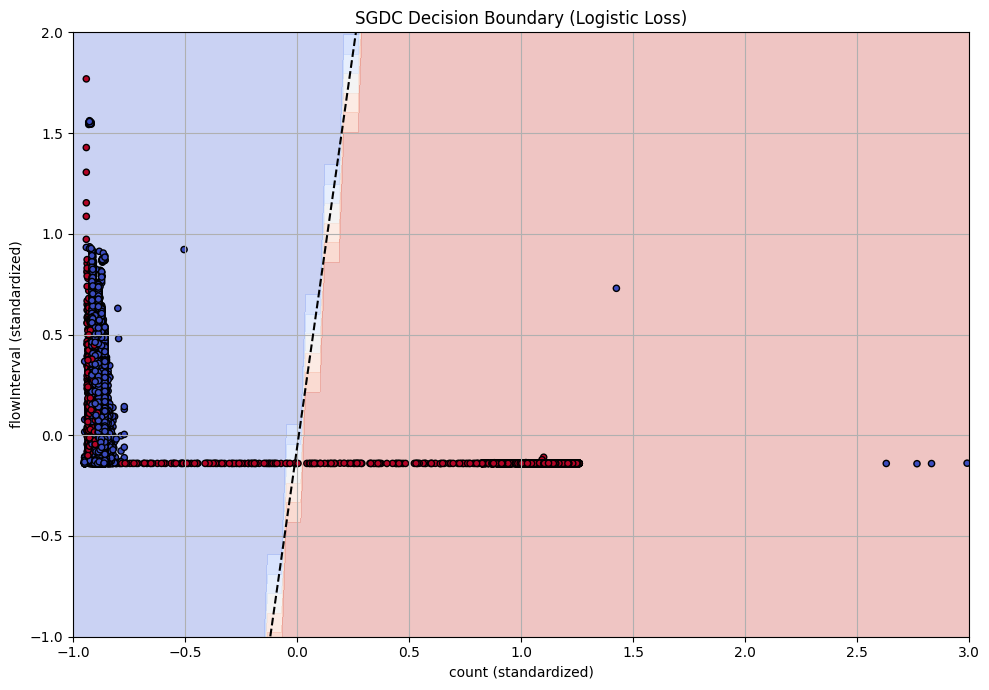

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

features = ['count', 'flowInterval']
X_vis = X_train[features]
y_vis = y_train

pipeline_sgd = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SGDClassifier(alpha=1, eta0=0.1, learning_rate='adaptive',
                               loss='log_loss', max_iter=100))
])

pipeline_sgd.fit(X_vis, y_vis)
scaler = pipeline_sgd.named_steps['scaler']
X_scaled = scaler.transform(X_vis)

x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))


grid_scaled = np.c_[xx.ravel(), yy.ravel()]
grid_original = scaler.inverse_transform(grid_scaled)
Z = pipeline_sgd.predict(grid_original).reshape(xx.shape)


plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

mask = X_scaled[:, 1] < 5
plt.scatter(X_scaled[mask, 0], X_scaled[mask, 1], c=y_vis[mask], cmap='coolwarm', edgecolor='k', s=20)

plt.title("SGDC Decision Boundary (Logistic Loss)")
plt.xlabel(f"{features[0]} (standardized)")
plt.ylabel(f"{features[1]} (standardized)")
plt.grid(True)
plt.ylim(-1, 2)
plt.xlim(-1, 3)
plt.tight_layout()
clf = pipeline_sgd.named_steps['classifier']
coef = clf.coef_[0]
intercept = clf.intercept_[0]
x_vals = np.linspace(-2, 2, 100)
y_vals = -(coef[0] * x_vals + intercept) / coef[1]

plt.plot(x_vals, y_vals, 'k--', label='Decision Boundary')

plt.show()


In [173]:
cv = cross_validate(pipeline_LR, 
                    X_train, 
                    y_train, 
                    cv = 5, scoring = ['accuracy', 'precision', 'recall', 'f1'],
                    return_train_score = True)
print(pd.DataFrame(cv))

   fit_time  score_time  test_accuracy  train_accuracy  test_precision  \
0    0.0378      0.0133         0.9414          0.9386          0.9955   
1    0.0269      0.0150         0.9379          0.9394          0.9963   
2    0.0261      0.0168         0.9360          0.9399          0.9965   
3    0.0257      0.0121         0.9403          0.9388          0.9966   
4    0.0261      0.0147         0.9400          0.9389          0.9949   

   train_precision  test_recall  train_recall  test_f1  train_f1  
0           0.9961       0.8865        0.8804   0.9379    0.9347  
1           0.9959       0.8787        0.8822   0.9338    0.9356  
2           0.9958       0.8747        0.8832   0.9317    0.9361  
3           0.9958       0.8835        0.8810   0.9366    0.9349  
4           0.9962       0.8842        0.8808   0.9363    0.9350  


In [181]:
print(cv['test_accuracy'])

[0.94138258 0.93787879 0.93598485 0.94034091 0.93996212]


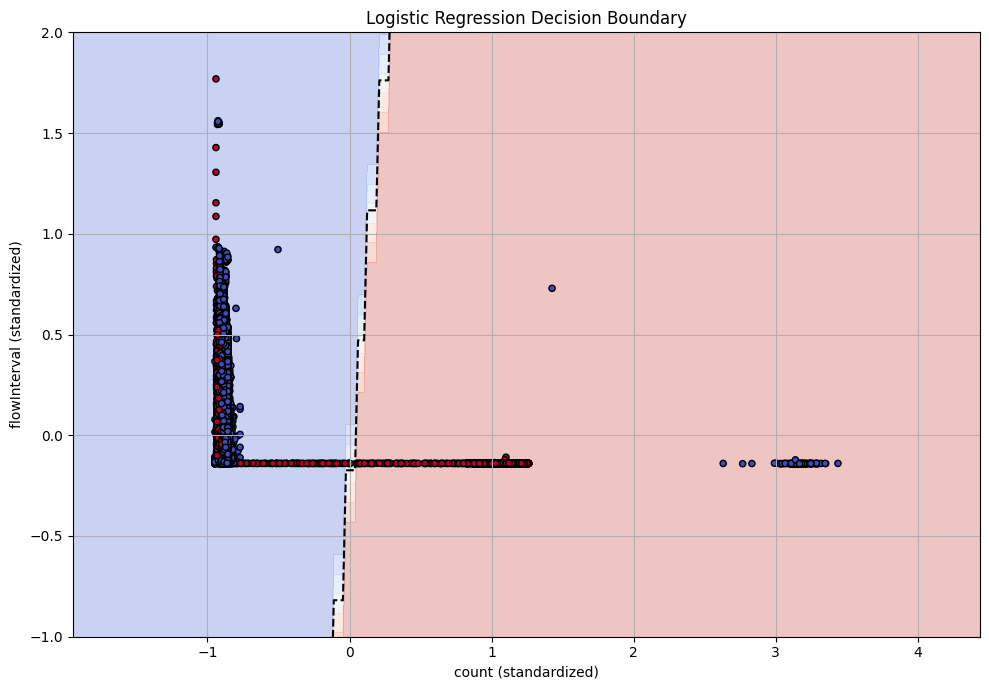

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

features = ['count', 'flowInterval']
X_vis = X_train[features]
y_vis = y_train

pipeline_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(C=1e-05))
])

pipeline_logreg.fit(X_vis, y_vis)
scaler = pipeline_logreg.named_steps['scaler']
X_scaled = scaler.transform(X_vis)

x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

grid_scaled = np.c_[xx.ravel(), yy.ravel()]
grid_df = pd.DataFrame(scaler.inverse_transform(grid_scaled), columns=features)

Z = pipeline_logreg.predict(grid_df).reshape(xx.shape)

plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.3)
plt.contour(xx, yy, Z, levels=[0.5], colors='k', linestyles='--')

mask = X_scaled[:, 1] < 5
plt.scatter(X_scaled[mask, 0], X_scaled[mask, 1], c=y_vis[mask], cmap='coolwarm', edgecolor='k', s=20)
plt.title("Logistic Regression Decision Boundary")
plt.xlabel("count (standardized)")
plt.ylabel("flowInterval (standardized)")
plt.ylim(-1, 2)
plt.grid(True)
plt.tight_layout()
plt.show()


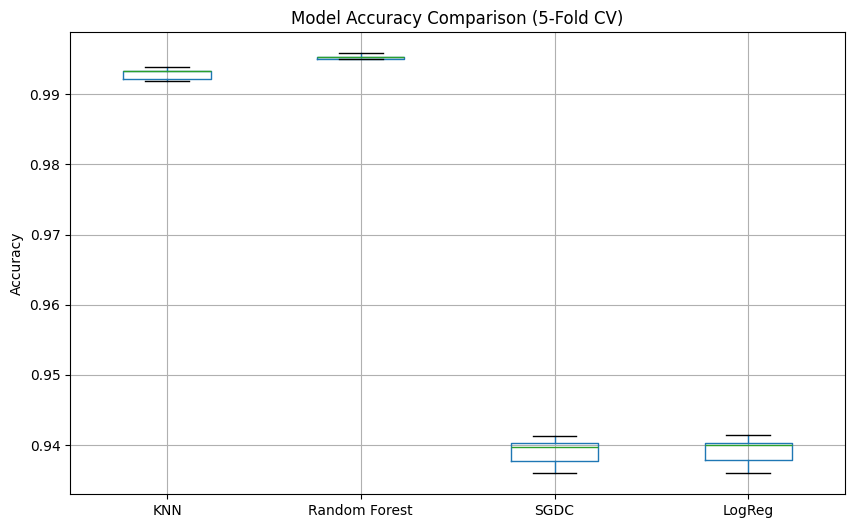

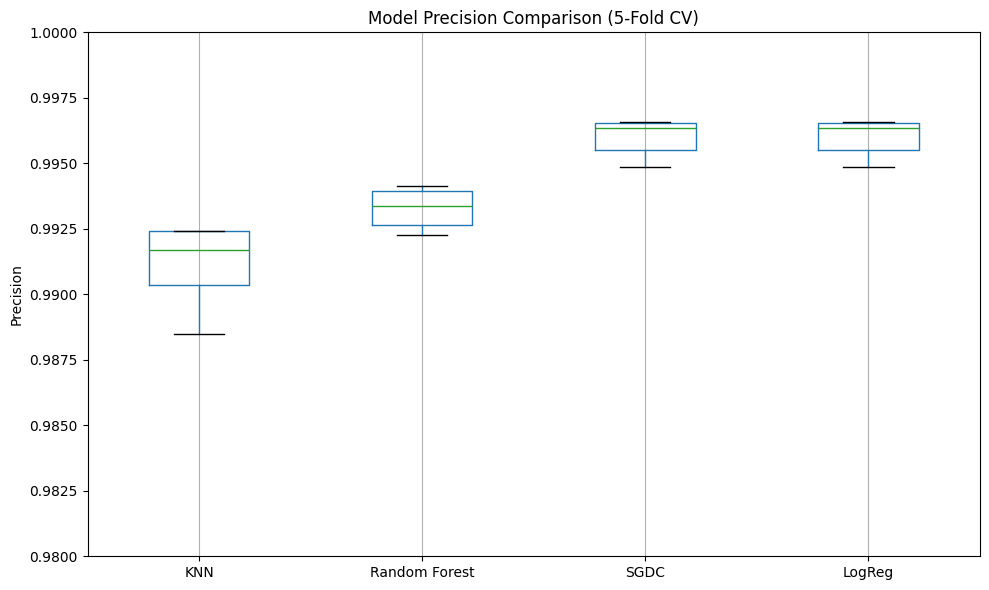

In [189]:
from sklearn.model_selection import cross_val_score

models = {
    "KNN": pipeline_KNN,
    "Random Forest": pipeline_RFC,
    "SGDC": pipeline_SD,
    "LogReg": pipeline_LR
}

results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    results[name] = scores

precision_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')
    precision_results[name] = scores

df_results = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
df_results.boxplot()
plt.title("Model Accuracy Comparison (5-Fold CV)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

df_precision = pd.DataFrame(precision_results)

plt.figure(figsize=(10, 6))
df_precision.boxplot()
plt.title("Model Precision Comparison (5-Fold CV)")
plt.ylabel("Precision")
plt.ylim(0.98, 1) 
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
##Checking Correlation of all features to target label ONLY

In [ ]:
#Finding correlation between all features, checking for redudancy 

In [99]:
#normalize features to common scale, using min-max scaling
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

X_train_normalized = pd.DataFrame(X_train_normalized, columns=X_train.columns)
X_test_normalized = pd.DataFrame(X_test_normalized, columns=X_test.columns)

X_train_normalized['label'] = y_train.values
X_test_normalized['label'] = y_test.values
print(X_train_normalized.describe().loc[['min','max']].transpose())





                 min      max
flowStart    -1.2421   2.5438
flowInterval -0.1414 190.7503
count        -0.9474   3.4384
label         0.0000   1.0000


In [ ]:
#apply PCA
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

pca1 = PCA()
pca2 = PCA(0.95)
X_pca1 = pca1.fit_transform(X_train)
X_pca2 = pca2.fit_transform(X_train)

print("\nExplained variance ratio for each principal component (all components):")
for i, ratio in enumerate(pca1.explained_variance_ratio_, start=1):
    print(f"  Component {i}: {ratio:.4f}")

cumulative_variance = np.cumsum(pca1.explained_variance_ratio_)
print("\nCumulative explained variance for all components:")
for i, cumulative in enumerate(cumulative_variance, start=1):
    print(f"  Up to Component {i}: {cumulative:.4f}")

print(f"\nMinimum number of components to explain at least 95% variance: {pca2.n_components_}")
print("Explained variance ratio for these selected components:")
for i, ratio in enumerate(pca2.explained_variance_ratio_, start=1):
    print(f"  Component {i}: {ratio:.4f}")

plt.figure()
plt.bar(range(1, len(pca1.explained_variance_)+1),pca1.explained_variance_)
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1, len(pca1.explained_variance_)+1),
         np.cumsum(pca1.explained_variance_),
         c='red',
         label="Cumulative explained variance")
plt.legend(loc='lower right')
plt.show()

pca2c = PCA(n_components=2)
pca3c = PCA(n_components=3)
X_pca2c = pca2c.fit_transform(X_train)
X_pca3c = pca3c.fit_transform(X_train)

plt.figure()
scatter = plt.scatter(X_pca2c[:, 0], X_pca2c[:, 1], c=y_train)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter, label='DDoS')
plt.show()


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter3d = ax.scatter(X_pca3c[:, 0], X_pca3c[:, 1], X_pca3c[:, 2], c=y_train, cmap='viridis', alpha=0.7)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Scatterplot')
fig.colorbar(scatter3d, ax=ax, label='DDoS')
plt.show()



In [ ]:
"""
PCA loadings are the coefficients of the linear combination of 
the original variables from which the principal components (PCs) are constructed.
describe how much each variable contributes to a particular principal component. 
Large loadings (positive or negative) indicate that a particular variable strongly 
relates to a particular principal component.
"""

component_labels = [f'PC{i+1}' for i in range(pca2.n_components_)]
loadings_df = pd.DataFrame(pca2.components_, columns=X_train.columns, index=component_labels)


# For each pc sort features by absolute loading values
for pc in loadings_df.index:
    sorted_loadings = loadings_df.loc[pc].abs().sort_values(ascending=False)
    print(f"Key features for {pc} :")
    print(sorted_loadings, "\n")

#heatmap for a visual interpretation of the loadings
plt.figure(figsize=(10, 4))
sns.heatmap(loadings_df, annot=True, cmap="coolwarm", center=0)
plt.title("PCA Component Loadings Heatmap")
plt.xlabel("Original Features")
plt.ylabel("Principal Components")
plt.show()

#bar charts for each principal component's loadings
for pc in loadings_df.index:
    plt.figure(figsize=(8, 4))
    sorted_features = loadings_df.loc[pc].abs().sort_values(ascending=False)
    sorted_features.plot(kind='bar', color='skyblue')
    plt.title(f"{pc} - Sorted Feature Loadings (Absolute Values)")
    plt.xlabel("Features")
    plt.ylabel("Absolute Loading Value")
    plt.tight_layout()
    plt.show()

In [ ]:
# Save features and labels separately
X_train.to_csv("X_train_preprocessed.csv", index=False)
X_test.to_csv("X_test_preprocessed.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)
